In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pickle

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import BatchNormalization
from keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Dropout, MaxPooling1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


In [3]:
MITdf = pd.read_csv("/content/gdrive/MyDrive/ECG_Data/mitbih_train.csv", header = None, index_col= False)
raw_data = MITdf.values
MITdf.head()

0         1         2         3         4    ...  183  184  185  186  187
0  0.977941  0.926471  0.681373  0.245098  0.154412  ...  0.0  0.0  0.0  0.0  0.0
1  0.960114  0.863248  0.461538  0.196581  0.094017  ...  0.0  0.0  0.0  0.0  0.0
2  1.000000  0.659459  0.186486  0.070270  0.070270  ...  0.0  0.0  0.0  0.0  0.0
3  0.925414  0.665746  0.541436  0.276243  0.196133  ...  0.0  0.0  0.0  0.0  0.0
4  0.967136  1.000000  0.830986  0.586854  0.356808  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 188 columns]

In [6]:
MITdf_t = pd.read_pickle("/content/gdrive/MyDrive/ECG_Data/interpolation.pkl")
labels = raw_data[:,-1]
anomal_labels_itp = np.where(labels == 2.0, 1.0, labels)
anomal_labels_itp = np.where(labels == 3.0, 1.0, labels)
anomal_labels_itp = np.where(labels == 4.0, 1.0, labels)
print(anomal_labels_itp)
data_itp = MITdf_t.values

train_data_itp, test_data_itp, train_labels_itp, test_labels_itp = train_test_split(
    data_itp, anomal_labels_itp, test_size = 0.2, random_state = 21
)
train_data_pure_itp, test_data_pure_itp, train_labels_pure_itp, test_labels_pure_itp = train_test_split(
    data_itp, labels, test_size = 0.2, random_state = 21
)

[0. 0. 0. ... 1. 1. 1.]


In [7]:
labels = raw_data[:,-1]
anomal_labels = np.where(labels == 2.0, 1.0, labels)
anomal_labels = np.where(labels == 3.0, 1.0, labels)
anomal_labels = np.where(labels == 4.0, 1.0, labels)
print(anomal_labels)
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, anomal_labels, test_size = 0.2, random_state = 21
)
# symptom label이 포함된 data
train_data_pure, test_data_pure, train_labels_pure, test_labels_pure = train_test_split(
    data, labels, test_size = 0.2, random_state = 21
)

[0. 0. 0. ... 1. 1. 1.]


In [8]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [9]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [10]:
min_val = tf.reduce_min(train_data_itp)
max_val = tf.reduce_max(train_data_itp)

train_data_itp = (train_data_itp - min_val) / (max_val - min_val)
test_data_itp = (test_data_itp - min_val) / (max_val - min_val)

train_data_itp = tf.cast(train_data_itp, tf.float32)
test_data_itp = tf.cast(test_data_itp, tf.float32)

In [11]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data_itp = train_data_itp[~train_labels]
normal_test_data_itp = test_data_itp[~test_labels]

anomalous_train_data_itp = train_data[train_labels]
anomalous_test_data_itp = test_data_itp[test_labels]

In [12]:
def recon_sample(model, data):
  encoded_imgs = model.encoder(data).numpy()
  decoded_imgs = model.decoder(encoded_imgs).numpy()
  decoded_imgs = np.squeeze(decoded_imgs)

  plt.figure(figsize=(100,30))
  plt.plot(data[0], 'b')
  plt.plot(decoded_imgs[0], 'r')
  plt.fill_between(np.arange(187), decoded_imgs[0], data[0], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

In [13]:
def predict_roc(model, data, labels, threshold):
  predictions = model.predict(data)
  predictions = np.squeeze(predictions)
  mse = np.mean(np.power(data - predictions, 2), axis=1)
  fpr, tpr, thresholds_roc = roc_curve(labels, mse)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.001, 1])
  plt.ylim([0, 1.001])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  loss = tf.keras.losses.mae(predictions, data)
  pred_conv = tf.math.less(loss, threshold)
  print("Accuracy = {}".format(accuracy_score(~labels, pred_conv)))


In [14]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(32, activation="relu"),
      Dense(16, activation="relu"),
      Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Dense(16, activation="relu"),
      Dense(32, activation="relu"),
      Dense(187, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [15]:
class AnomalyDetector_Conv(Model):
  def __init__(self):
    super(AnomalyDetector_Conv, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(187, 1)),
      Conv1D(filters=64, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=64, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=64, kernel_size=6, strides=1, activation="relu"),
      Conv1DTranspose(filters=1, kernel_size=7, padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv = AnomalyDetector_Conv()
autoencoder_conv.compile(optimizer='adam', loss='mae')

In [16]:
def knn_model(k, x_train, y_train):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(x_train, y_train)
  return knn

def print_model_sample(model, x_test, y_test, sample_num):
  output = model.predict(x_test)
  output = output.clip(min=0)

  result = np.subtract(output, y_test)
  print(result)
  print(np.average(result))
  print(np.average(output))


In [17]:
def predict_ae(model, data, threshold):
  reconstructions = model(data)
  reconstructions = np.squeeze(reconstructions)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)


In [45]:

def print_knn(prediction, MITdata, test_data):
  for_count = 0
  for i in prediction:
    if i == False:
      anomal_party_with_class = MITdata[MITdf[187]!=0]
      anomal_party = anomal_party_with_class.iloc[:, 0:187].to_numpy()
      y_temp = MITdf[MITdf[187]!=0].iloc[:, 187].to_numpy()
      
      knn_ecg = knn_model(3, anomal_party, y_temp)

      I = knn_ecg.kneighbors([test_data[for_count]], n_neighbors=3, return_distance=False)
      knn_pred = knn_ecg.predict([test_data[for_count]])

      outputs = np.squeeze(anomal_party[I])
      count = 0
      plt.figure(figsize=(100,30), linewidth=10.0)
      for output in outputs:
        xx = np.arange(0,187)
        label_name = "nearest beat %d" % count
        plt.plot(xx, output, label = label_name)
        count+=1
      plt.plot(xx, test_data[for_count], label = "original", color = 'k')
      plt.legend(fontsize=50)
      plt.show()
    for_count += 1
    # tempolarily break
    if for_count >=15:
      break


In [19]:
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
114/114 [==============================] - 3s 13ms/step - loss: 0.2289 - val_loss: 0.1424
Epoch 2/20
114/114 [==============================] - 1s 10ms/step - loss: 0.1121 - val_loss: 0.0819
Epoch 3/20
114/114 [==============================] - 1s 11ms/step - loss: 0.0647 - val_loss: 0.0637
Epoch 4/20
114/114 [==============================] - 1s 10ms/step - loss: 0.0543 - val_loss: 0.0552
Epoch 5/20
114/114 [==============================] - 1s 10ms/step - loss: 0.0482 - val_loss: 0.0514
Epoch 6/20
114/114 [==============================] - 1s 10ms/step - loss: 0.0459 - val_loss: 0.0495
Epoch 7/20
114/114 [==============================] - 1s 10ms/step - loss: 0.0446 - val_loss: 0.0480
Epoch 8/20
114/114 [==============================] - 1s 10ms/step - loss: 0.0433 - val_loss: 0.0470
Epoch 9/20
114/114 [==============================] - 1s 10ms/step - loss: 0.0425 - val_loss: 0.0462
Epoch 10/20
114/114 [==============================] - 1s 11ms/step - loss: 0.0419 - val_lo

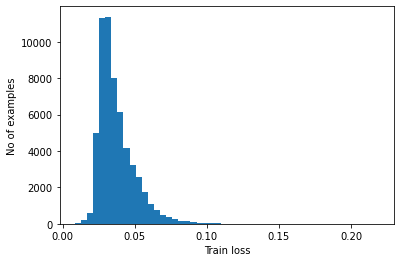

In [20]:
reconstructions_ae = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_ae, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
threshold_ae = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_ae)

Threshold:  0.05018024


normal_recon


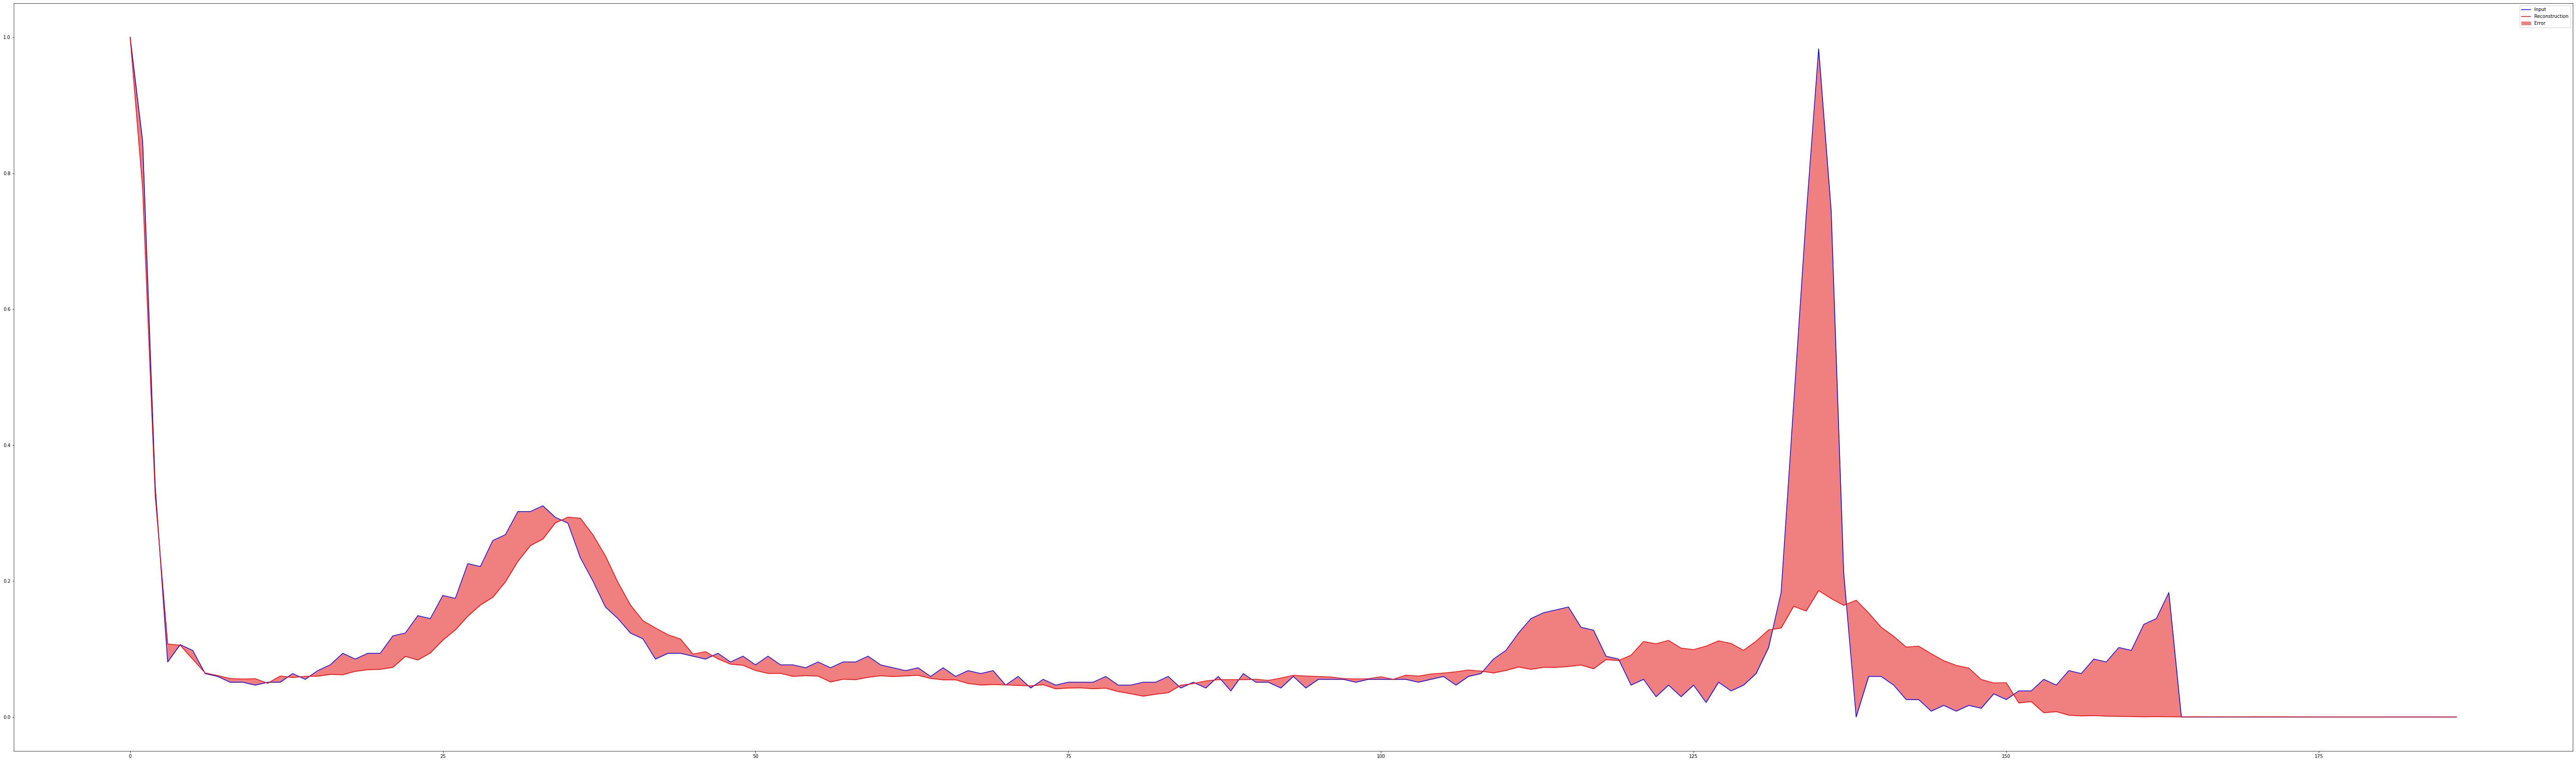

anomal_recon


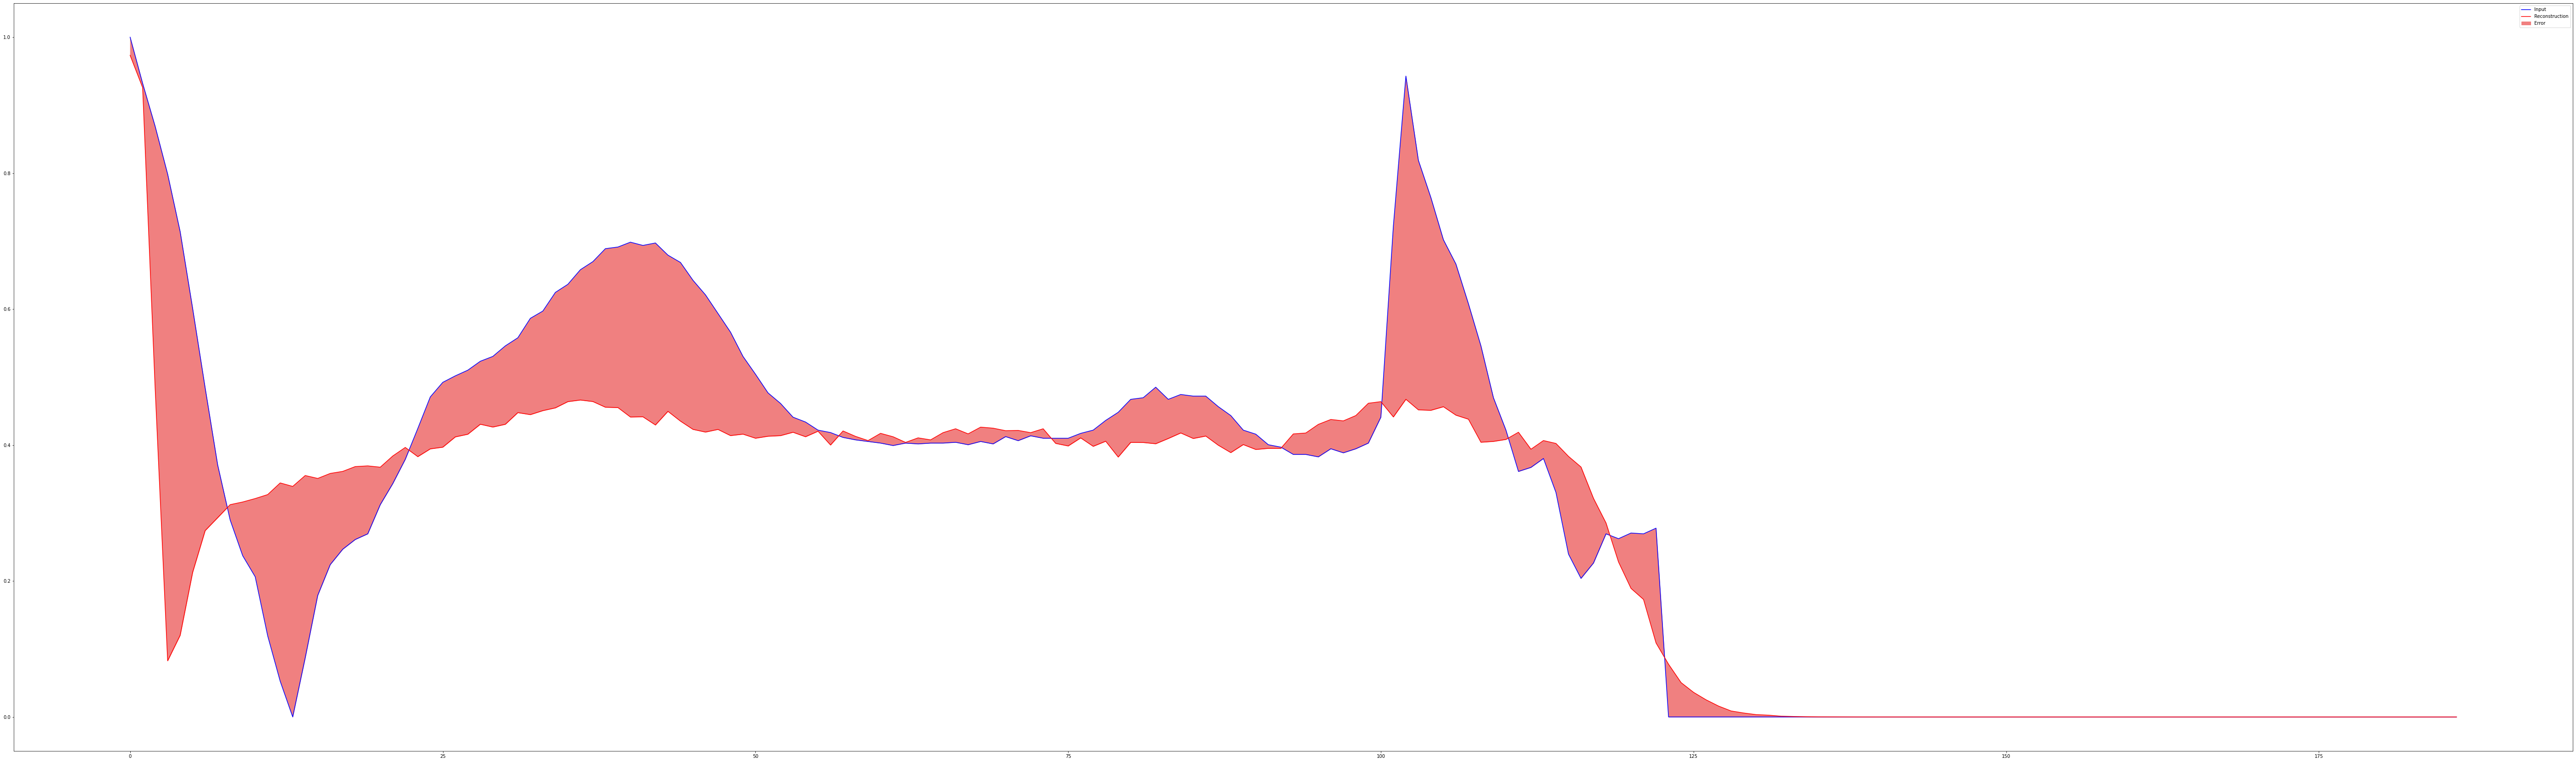

In [22]:
print("normal_recon")
recon_sample(autoencoder, normal_test_data)
print("anomal_recon")
recon_sample(autoencoder, anomalous_test_data)

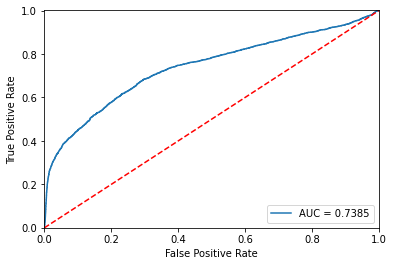

Accuracy = 0.8285077951002228


In [23]:
predict_roc(autoencoder, test_data, test_labels, threshold_ae)

In [24]:
history_conv = autoencoder_conv.fit(normal_train_data, normal_train_data, 
                                    epochs=10, 
                                    batch_size=512,
                                    validation_data=(test_data, test_data),
                                    shuffle=True)

Epoch 1/10
114/114 [==============================] - 152s 1s/step - loss: 0.0436 - val_loss: 0.0195
Epoch 2/10
114/114 [==============================] - 142s 1s/step - loss: 0.0151 - val_loss: 0.0128
Epoch 3/10
114/114 [==============================] - 140s 1s/step - loss: 0.0107 - val_loss: 0.0107
Epoch 4/10
114/114 [==============================] - 94s 826ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 5/10
114/114 [==============================] - 85s 749ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/10
114/114 [==============================] - 89s 785ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/10
114/114 [==============================] - 134s 1s/step - loss: 0.0075 - val_loss: 0.0071
Epoch 8/10
114/114 [==============================] - 131s 1s/step - loss: 0.0069 - val_loss: 0.0077
Epoch 9/10
114/114 [==============================] - 130s 1s/step - loss: 0.0067 - val_loss: 0.0069
Epoch 10/10
114/114 [==============================] - 134s 1s/step - loss: 0.0065 - 

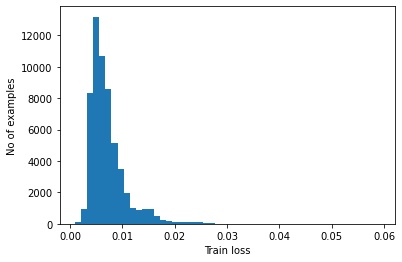

In [25]:
reconstructions_conv = autoencoder_conv.predict(normal_train_data)
reconstructions_conv = np.squeeze(reconstructions_conv)
train_loss = tf.keras.losses.mae(reconstructions_conv, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

normal_recon


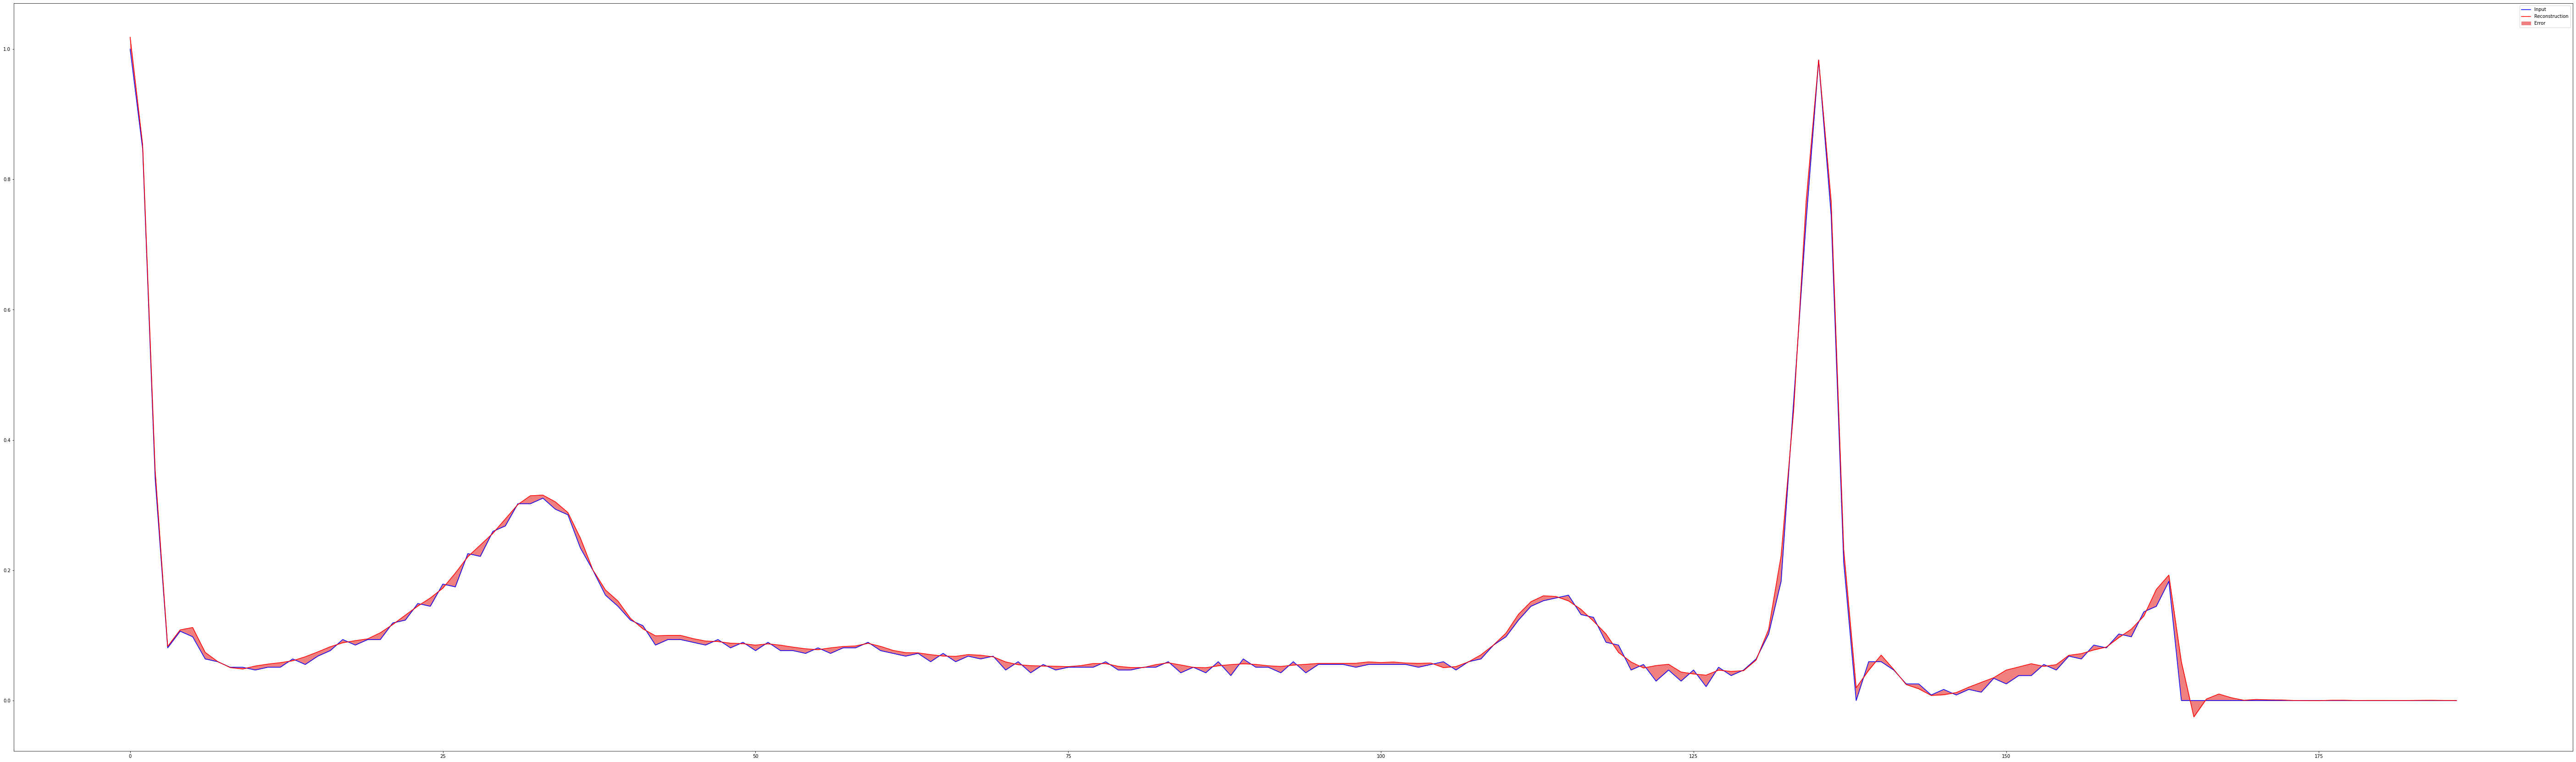

abnormal_recon


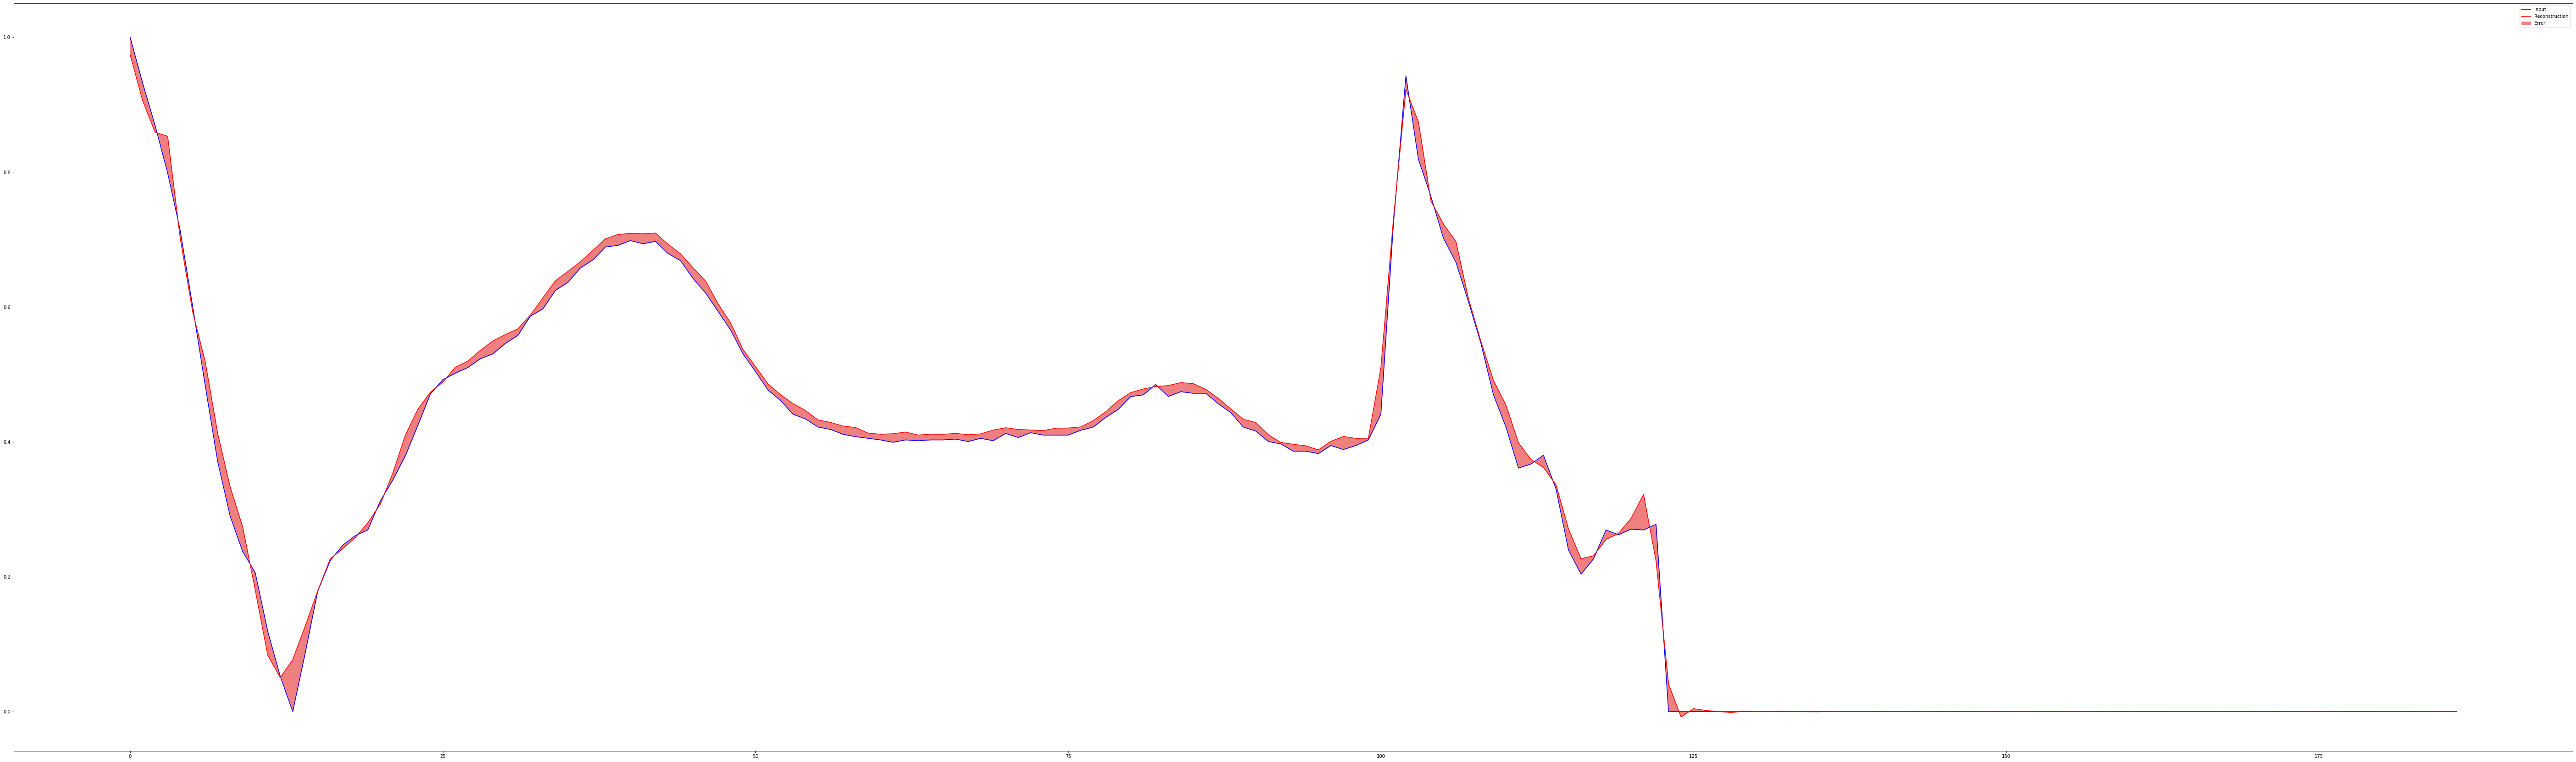

In [26]:
print("normal_recon")
recon_sample(autoencoder_conv, normal_test_data)
print("abnormal_recon")
recon_sample(autoencoder_conv, anomalous_test_data)

In [27]:
threshold_conv = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_conv)

Threshold:  0.0107566975


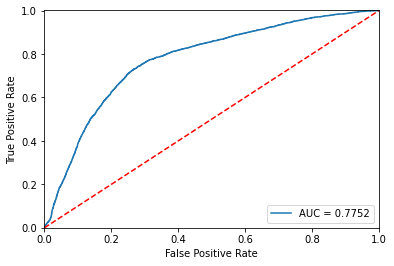

Accuracy = 0.8172577237165211


In [28]:
predict_roc(autoencoder_conv, test_data, test_labels, threshold_conv)

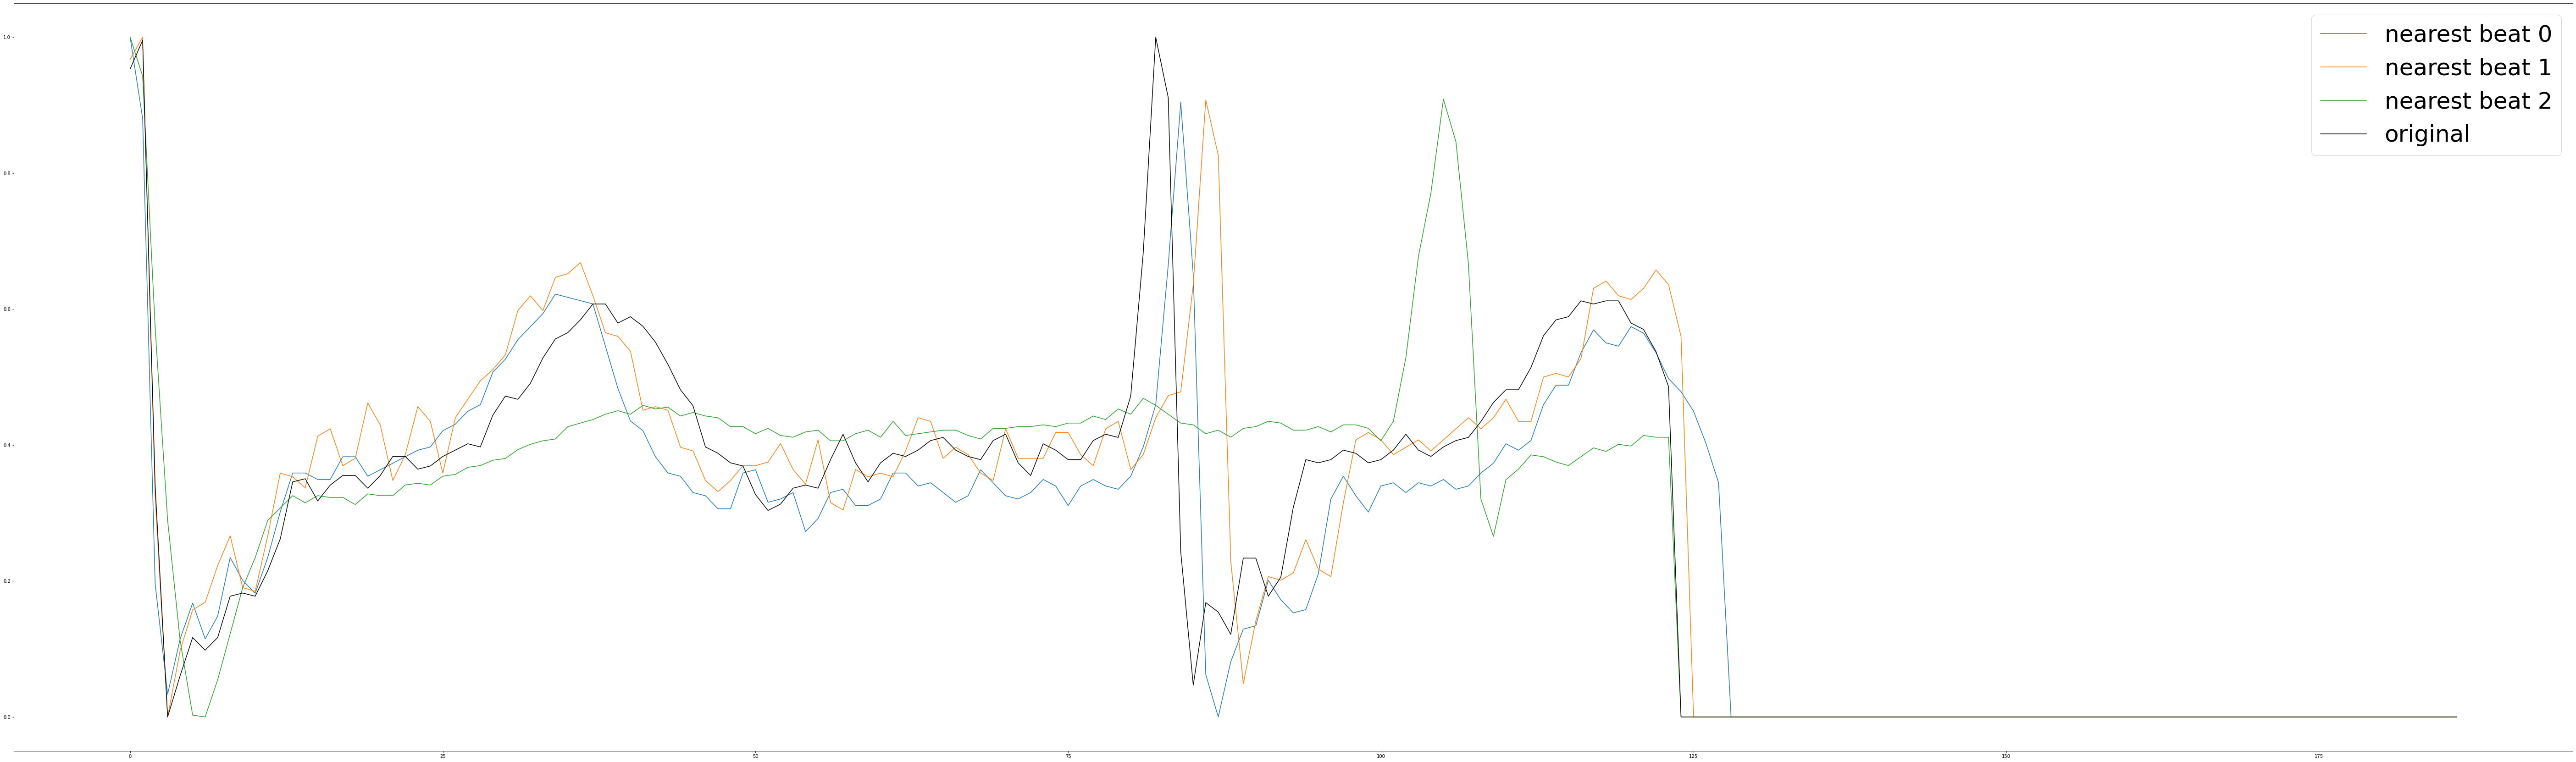

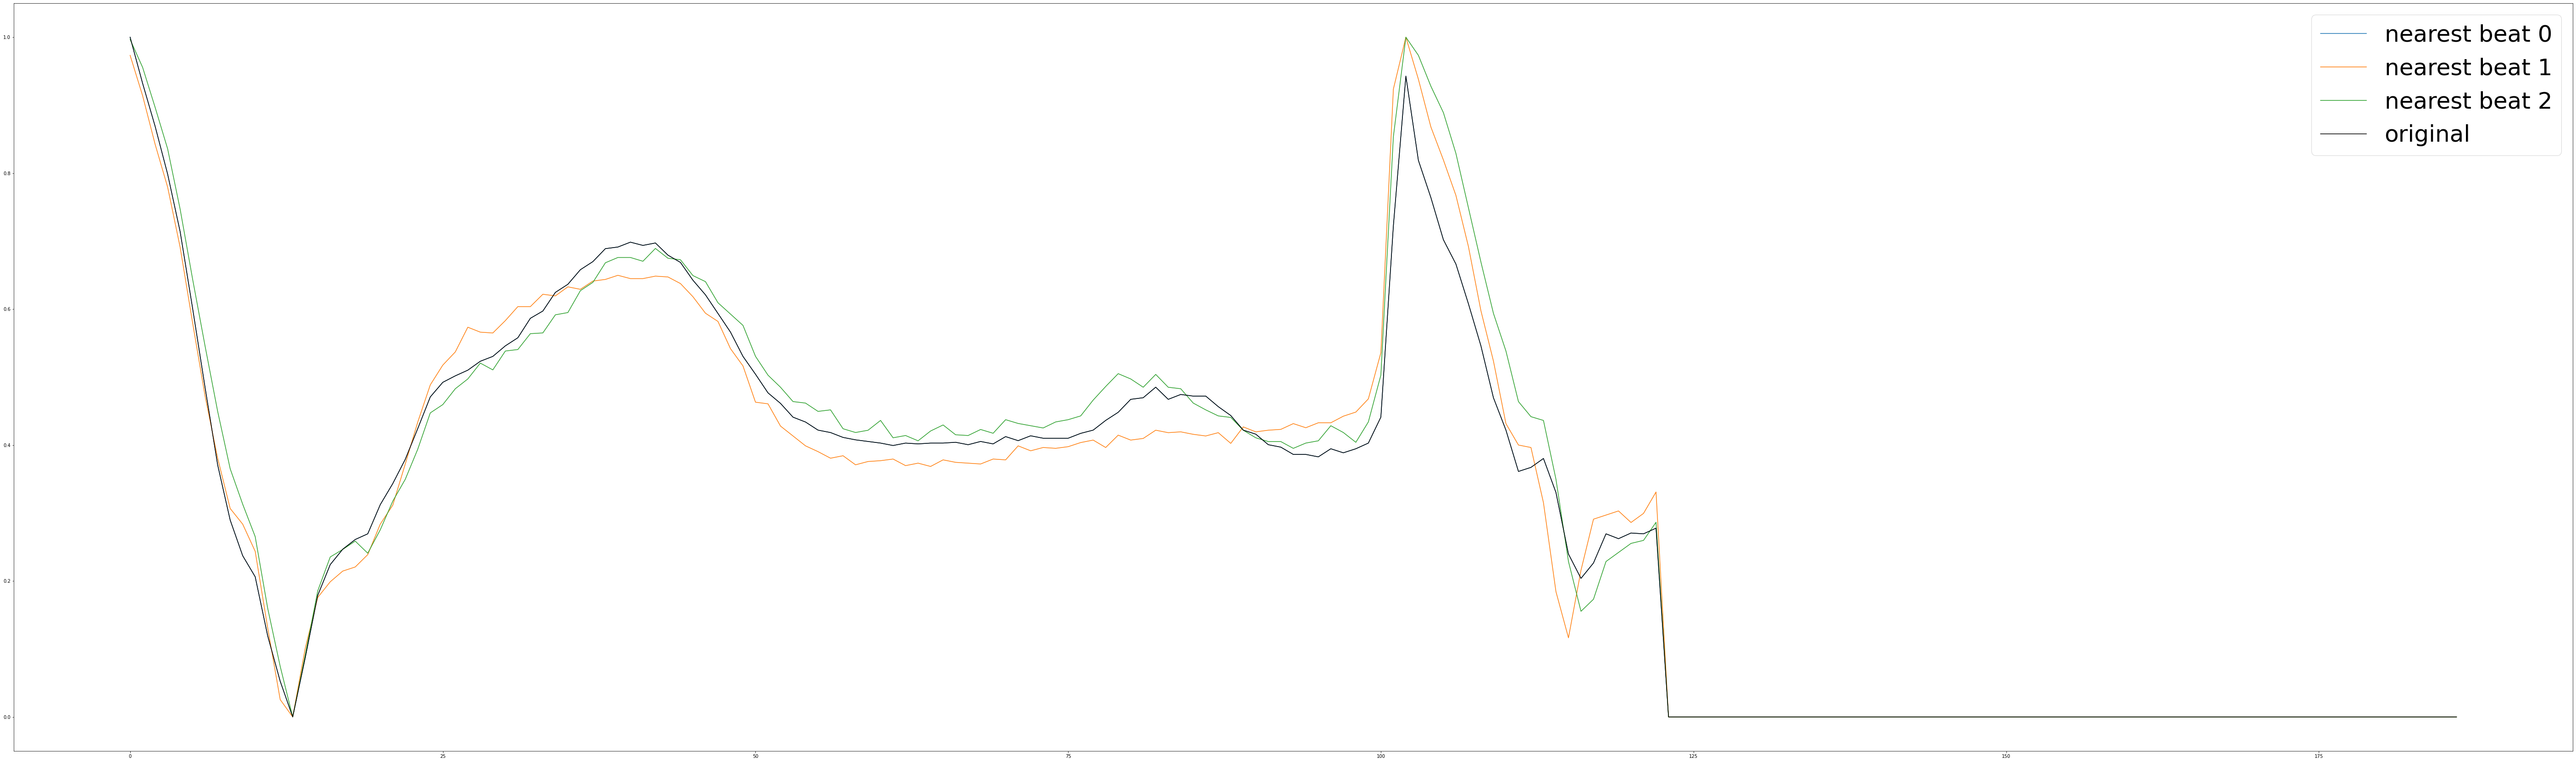

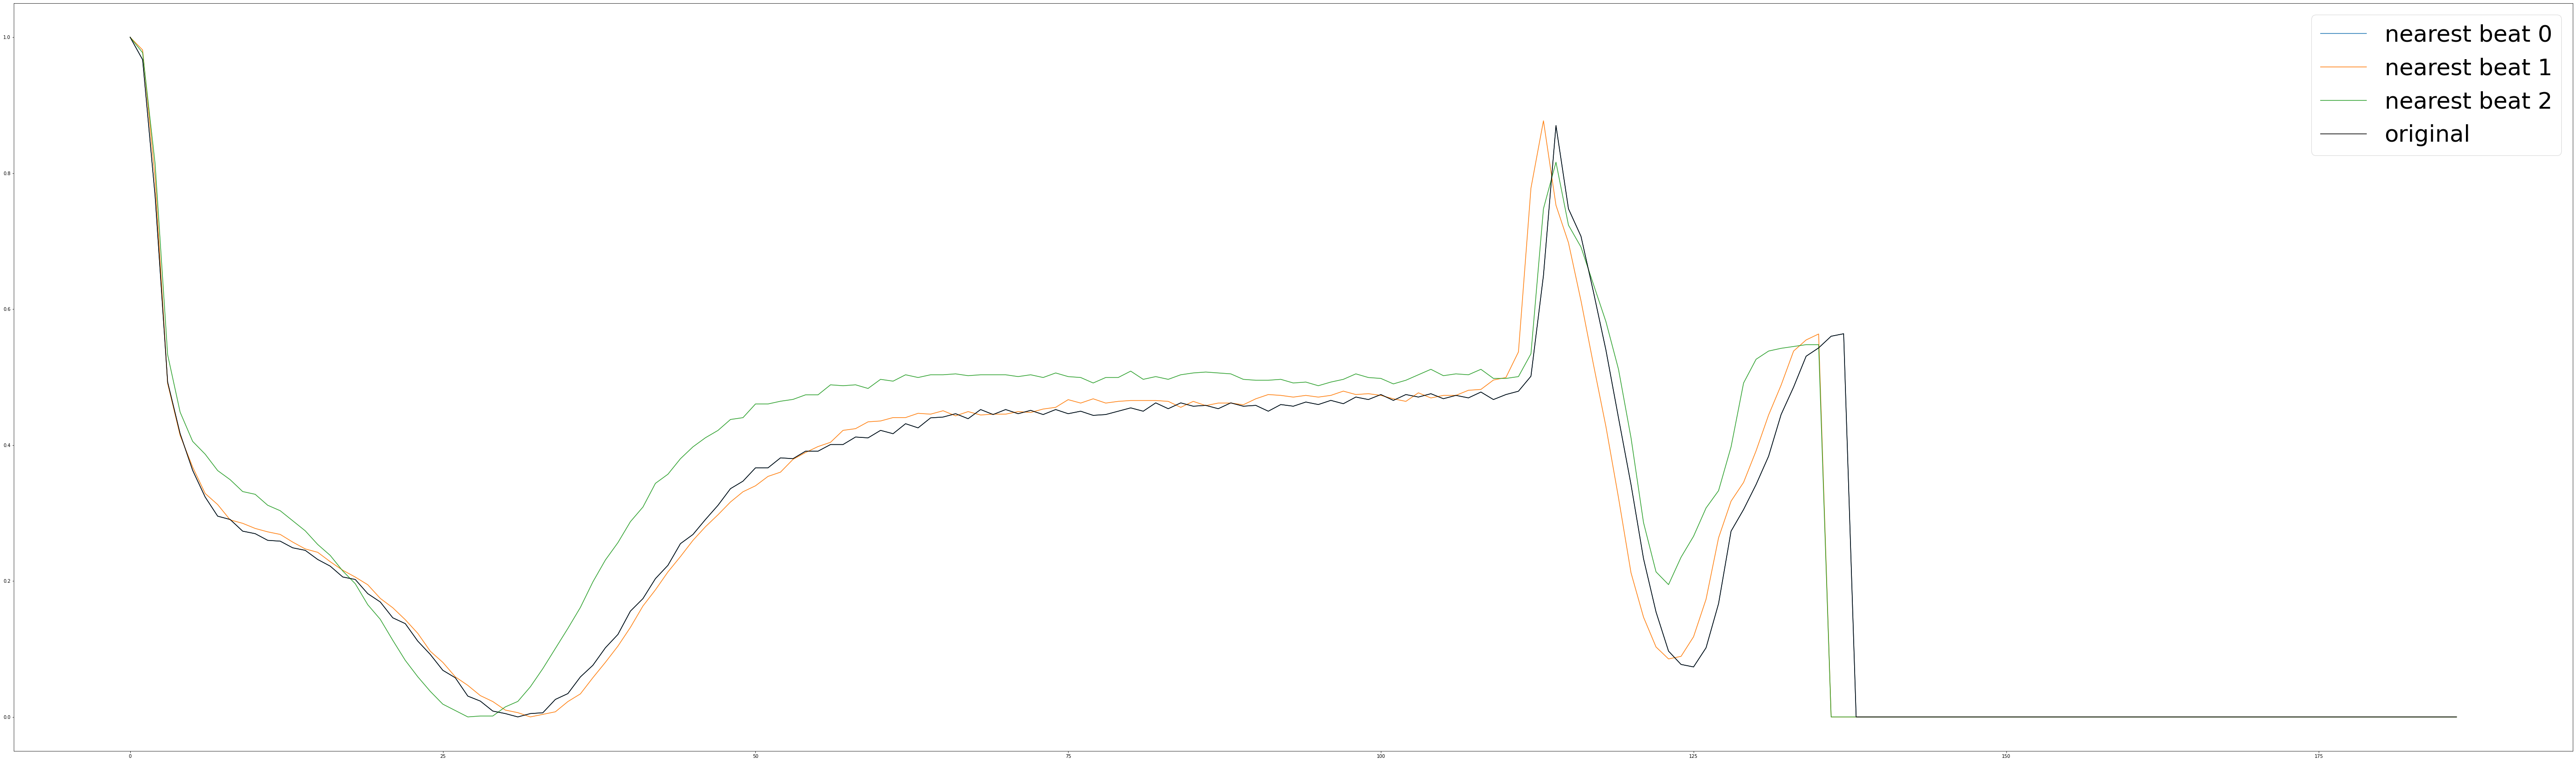

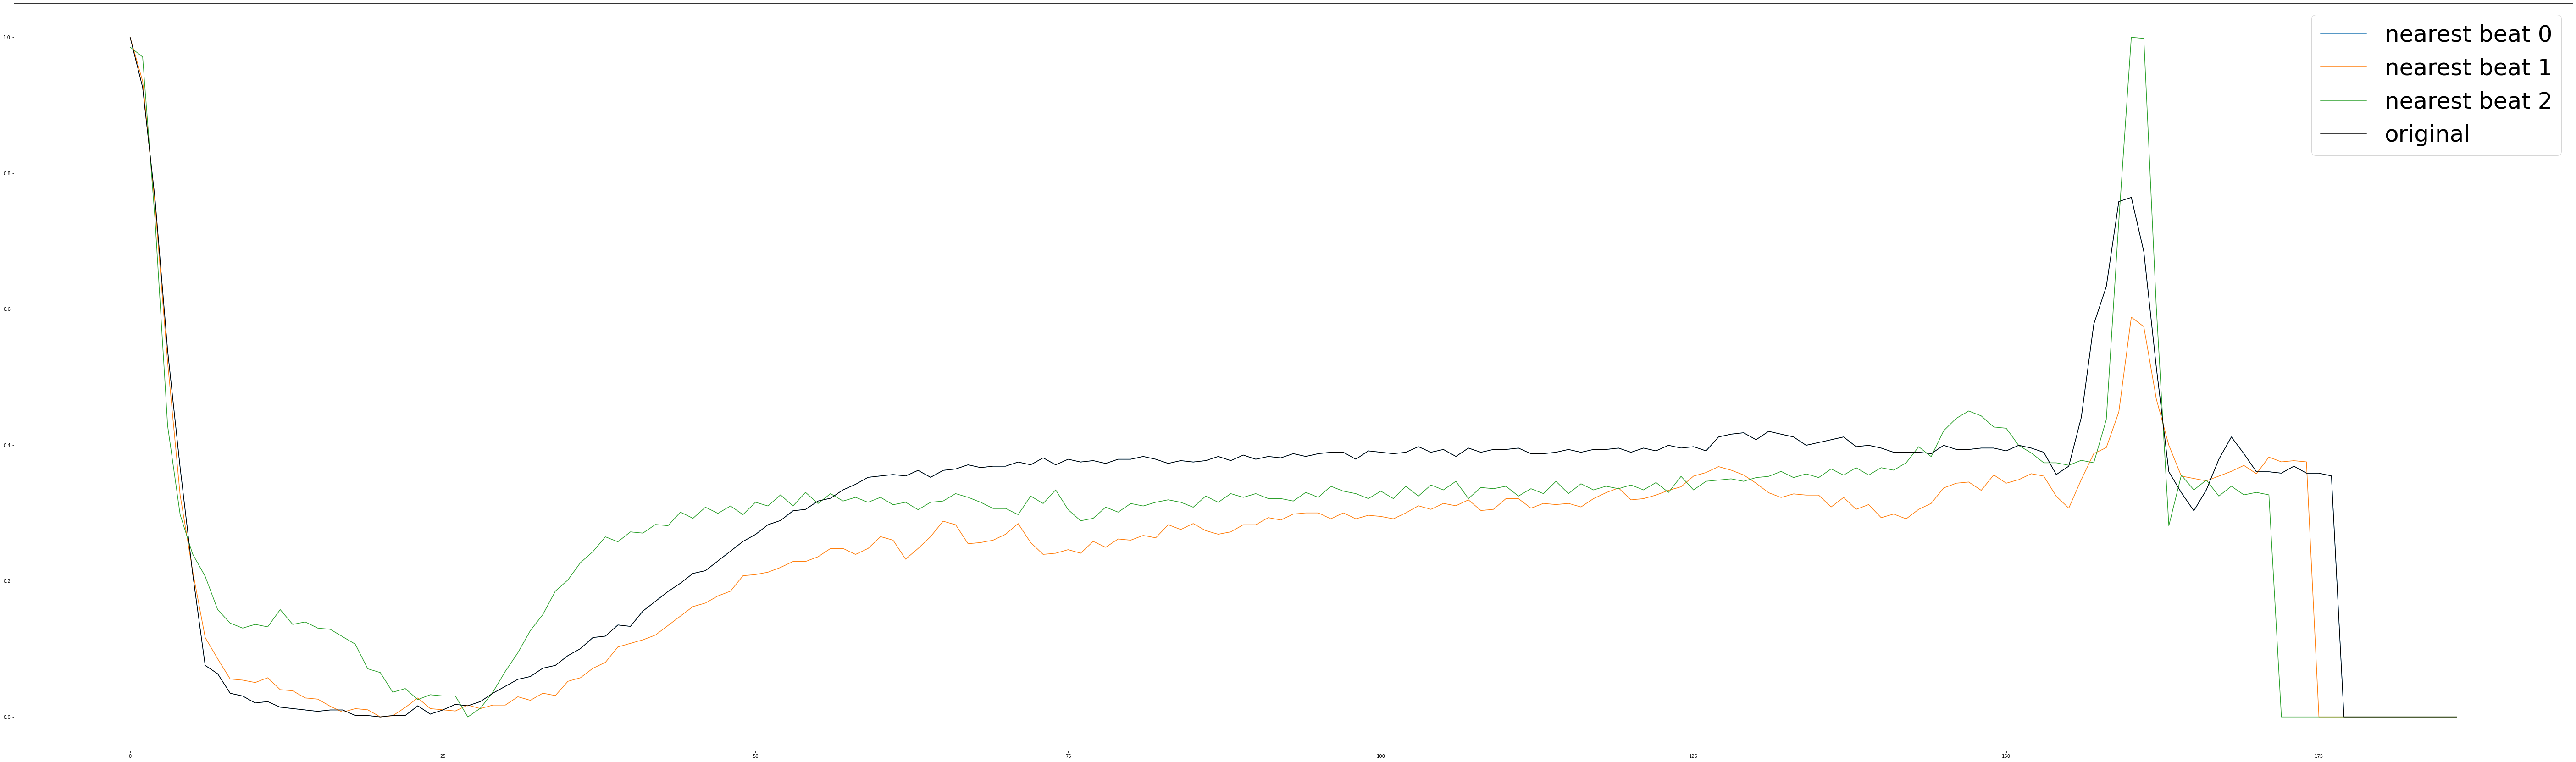

In [29]:
pred_ae = predict_ae(autoencoder, test_data, threshold_ae)
print_knn(pred_ae, MITdf, test_data_pure)

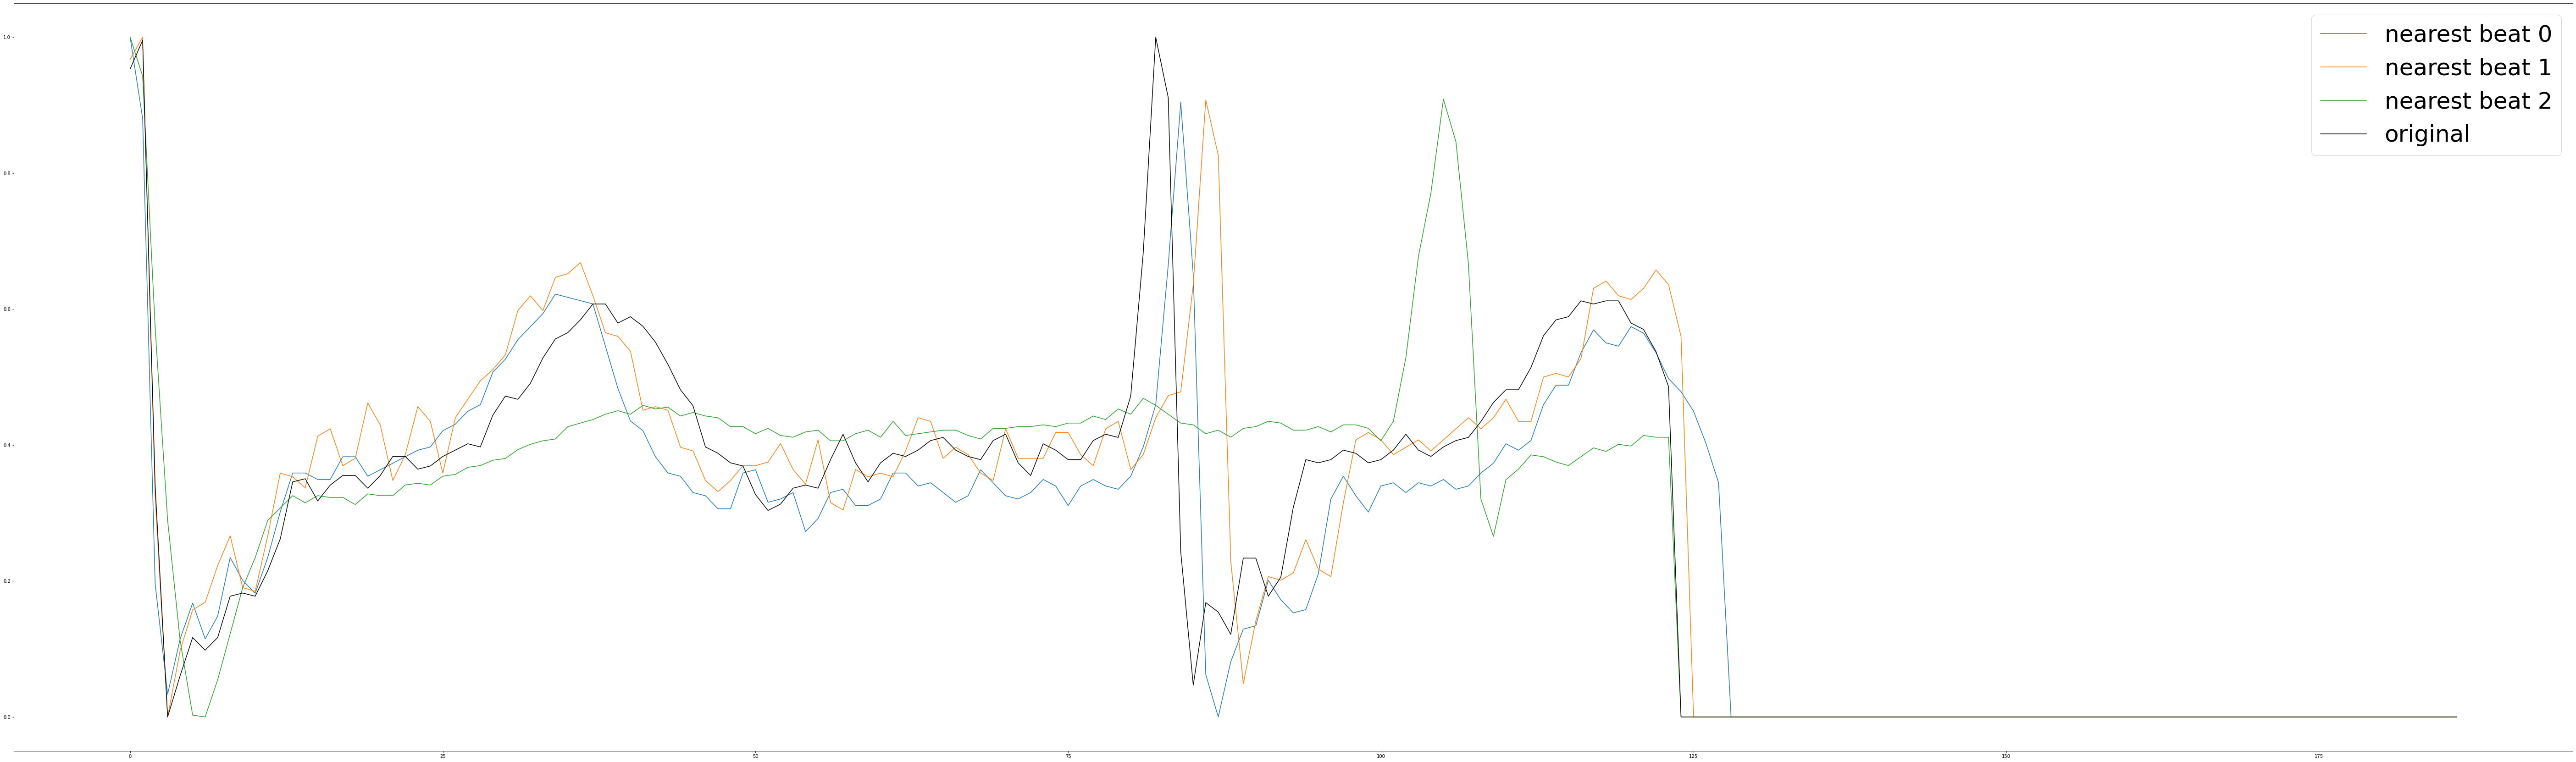

In [30]:
pred_conv = predict_ae(autoencoder_conv, test_data, threshold_conv)
print_knn(pred_conv, MITdf, test_data_pure)

In [31]:
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(normal_train_data_itp, normal_train_data_itp, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data_itp, test_data_itp),
          shuffle=True)

Epoch 1/20
114/114 [==============================] - 1s 8ms/step - loss: 0.0638 - val_loss: 0.0516
Epoch 2/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0383 - val_loss: 0.0361
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0302 - val_loss: 0.0309
Epoch 4/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0273 - val_loss: 0.0300
Epoch 5/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0264 - val_loss: 0.0288
Epoch 6/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0259 - val_loss: 0.0284
Epoch 7/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0255 - val_loss: 0.0279
Epoch 8/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0252 - val_loss: 0.0277
Epoch 9/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0250 - val_loss: 0.0274
Epoch 10/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0248 - val_loss: 0.0271

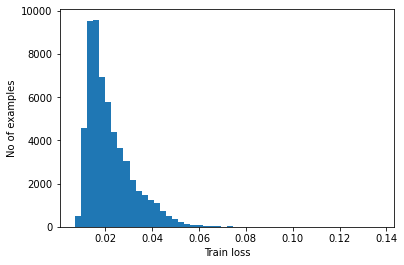

In [32]:
reconstructions_ae_itp = autoencoder.predict(normal_train_data_itp)
train_loss = tf.keras.losses.mae(reconstructions_ae_itp, normal_train_data_itp)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [33]:
threshold_ae_itp = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_ae_itp)

Threshold:  0.031850222


normal_recon


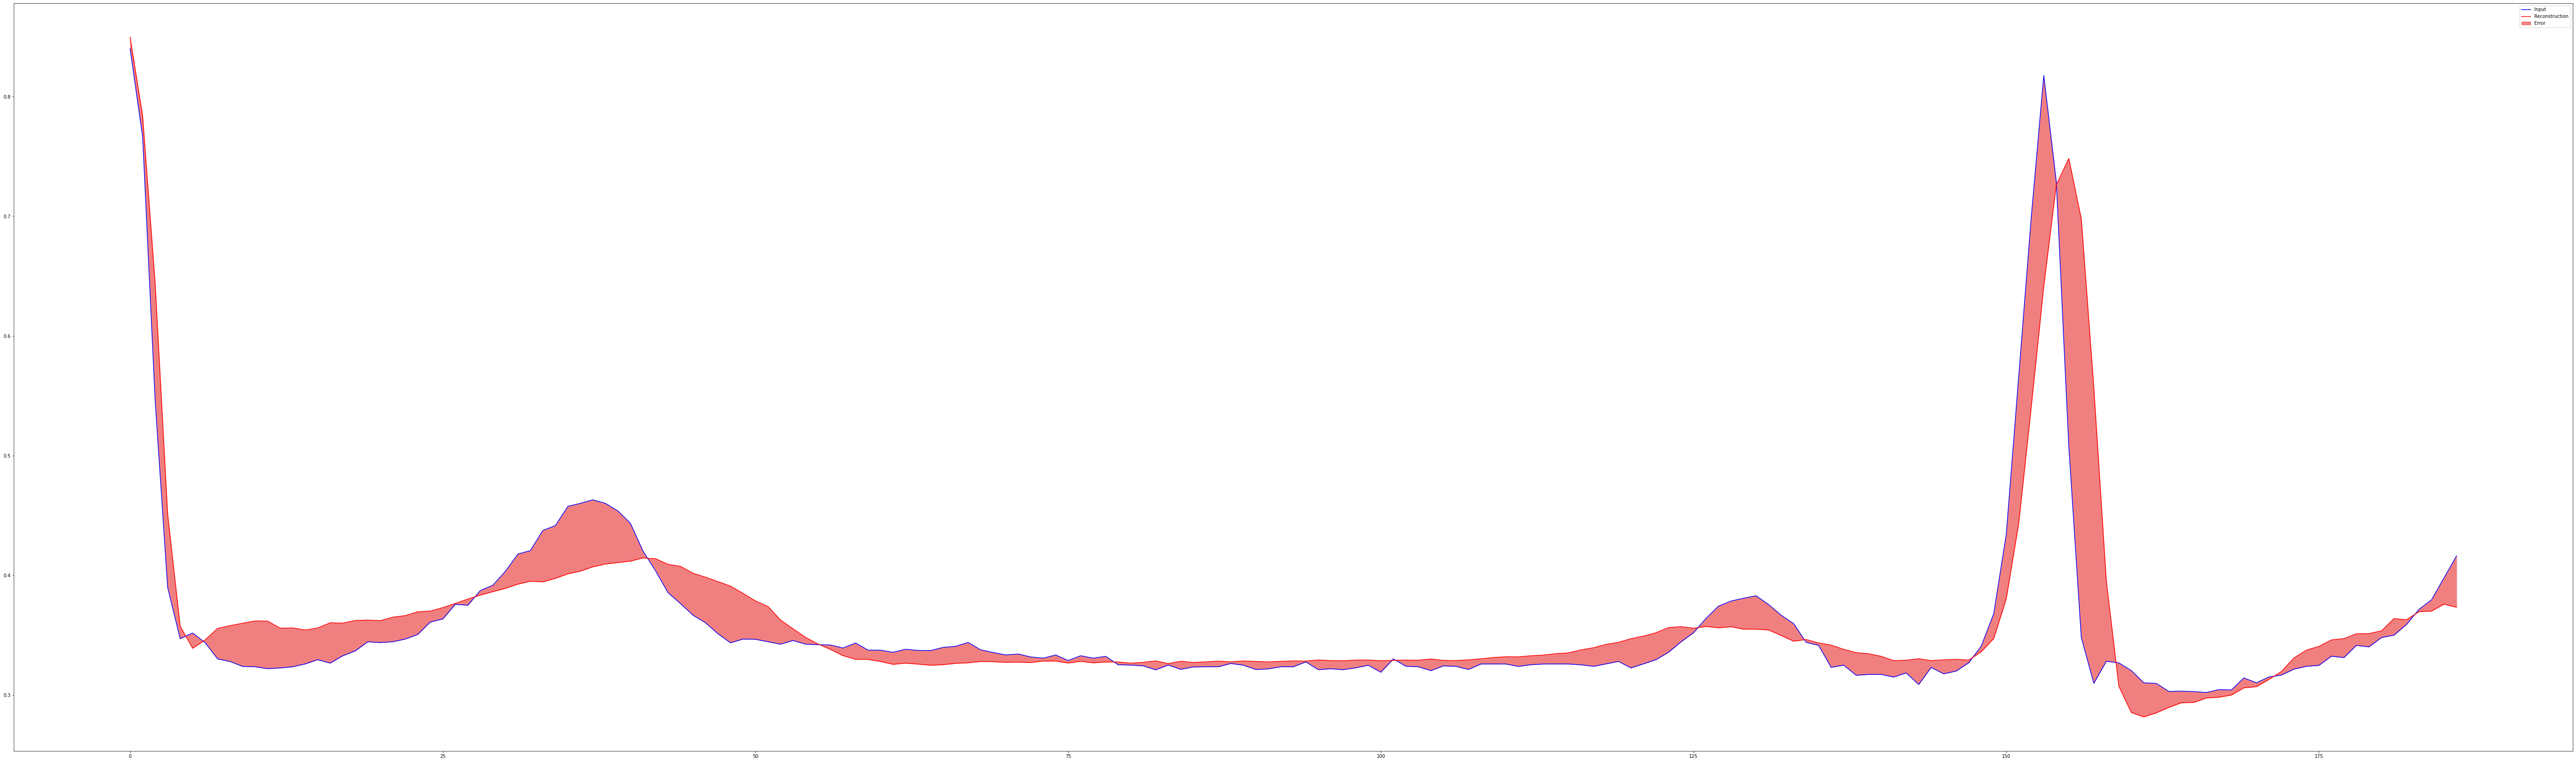

anomal_recon


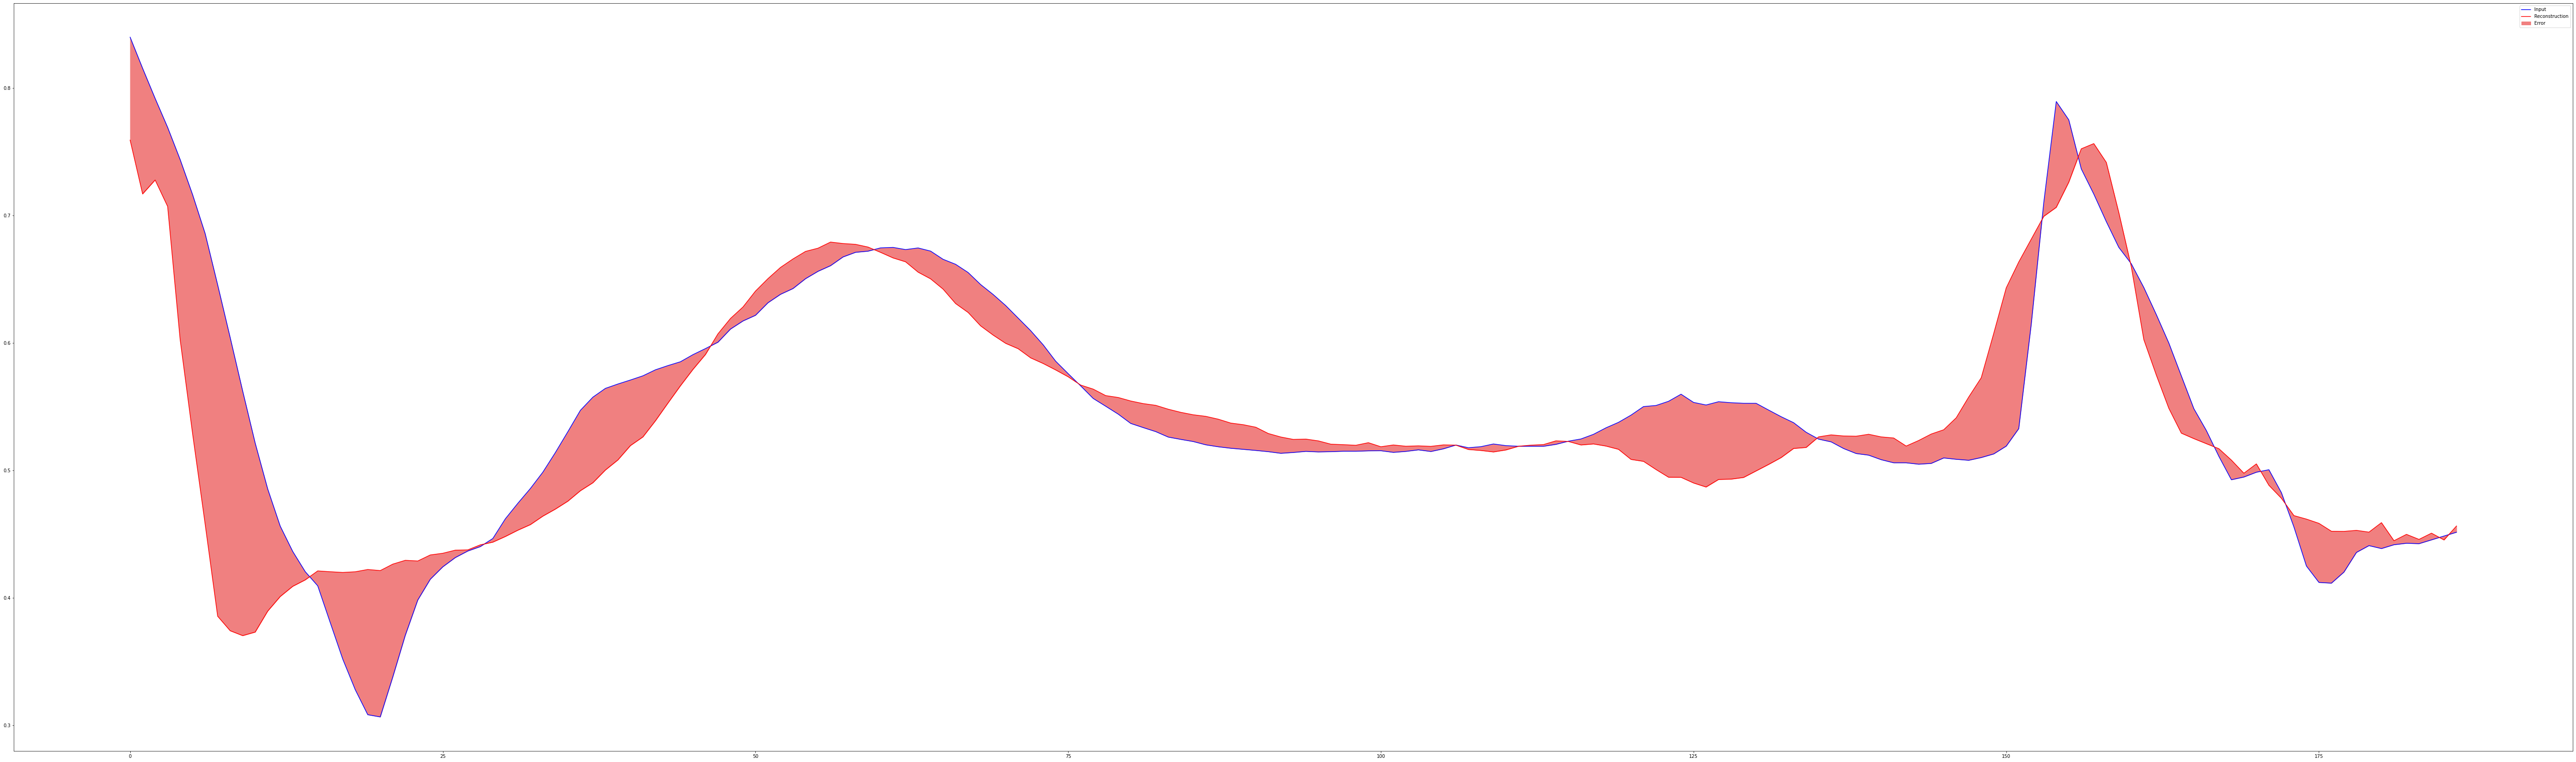

In [34]:
print("normal_recon")
recon_sample(autoencoder, normal_test_data_itp)
print("anomal_recon")
recon_sample(autoencoder, anomalous_test_data_itp)

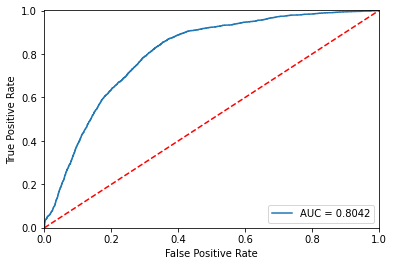

Accuracy = 0.806064759294158


In [35]:
predict_roc(autoencoder, test_data_itp, test_labels, threshold_ae_itp)

In [36]:
autoencoder_conv.compile(optimizer='adam', loss='mae')
history_conv = autoencoder_conv.fit(normal_train_data_itp, normal_train_data_itp, 
                                    epochs=10, 
                                    batch_size=512,
                                    validation_data=(test_data_itp, test_data_itp),
                                    shuffle=True)

Epoch 1/10
114/114 [==============================] - 135s 1s/step - loss: 0.0267 - val_loss: 0.0150
Epoch 2/10
114/114 [==============================] - 87s 765ms/step - loss: 0.0142 - val_loss: 0.0114
Epoch 3/10
114/114 [==============================] - 85s 749ms/step - loss: 0.0117 - val_loss: 0.0128
Epoch 4/10
114/114 [==============================] - 88s 775ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 5/10
114/114 [==============================] - 85s 749ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 6/10
114/114 [==============================] - 85s 748ms/step - loss: 0.0099 - val_loss: 0.0120
Epoch 7/10
114/114 [==============================] - 89s 778ms/step - loss: 0.0096 - val_loss: 0.0110
Epoch 8/10
114/114 [==============================] - 87s 762ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 9/10
114/114 [==============================] - 86s 756ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 10/10
114/114 [==============================] - 86s 758ms/step - los

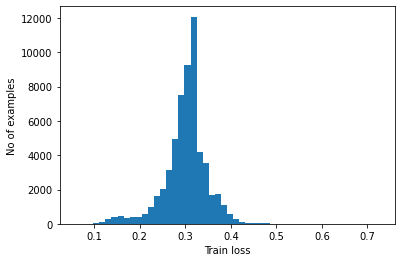

In [37]:
reconstructions_conv_itp = autoencoder_conv.predict(normal_train_data_itp)
reconstructions_conv_itp = np.squeeze(reconstructions_conv_itp)
train_loss = tf.keras.losses.mae(reconstructions_conv, normal_train_data_itp)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

normal_recon


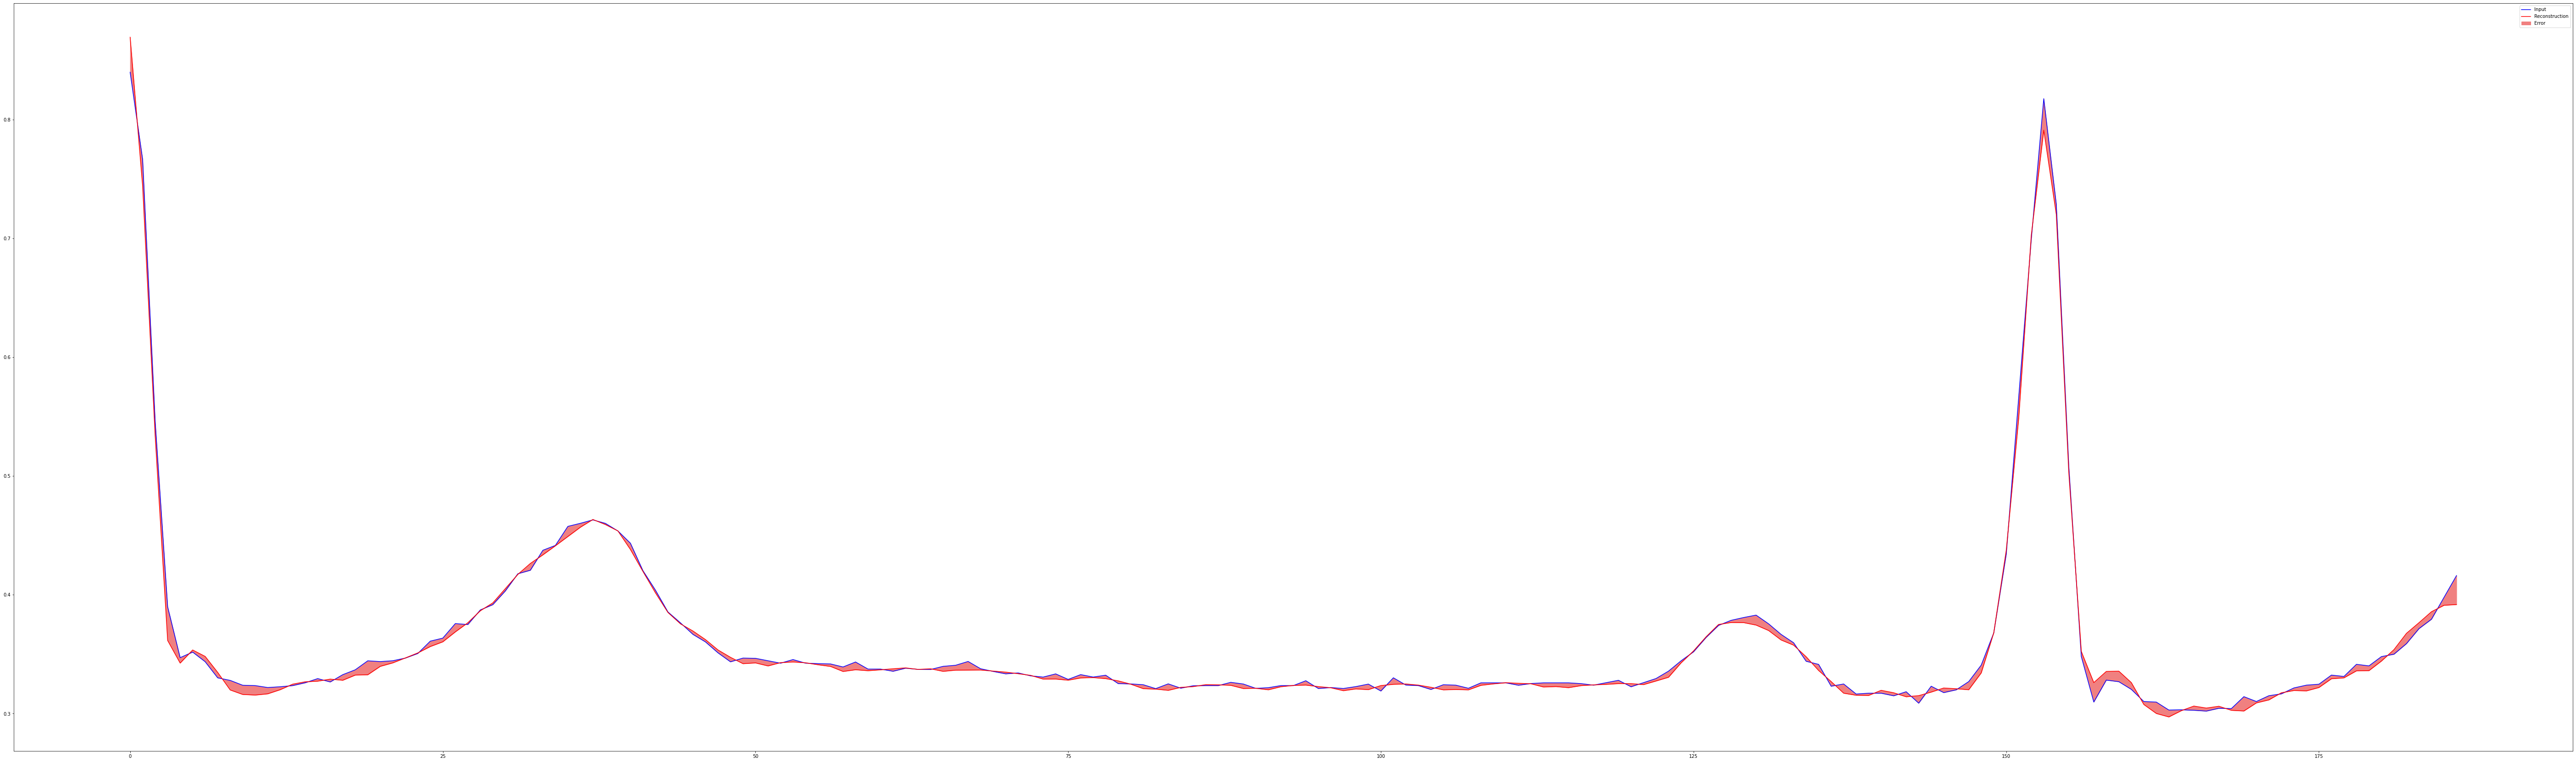

abnormal_recon


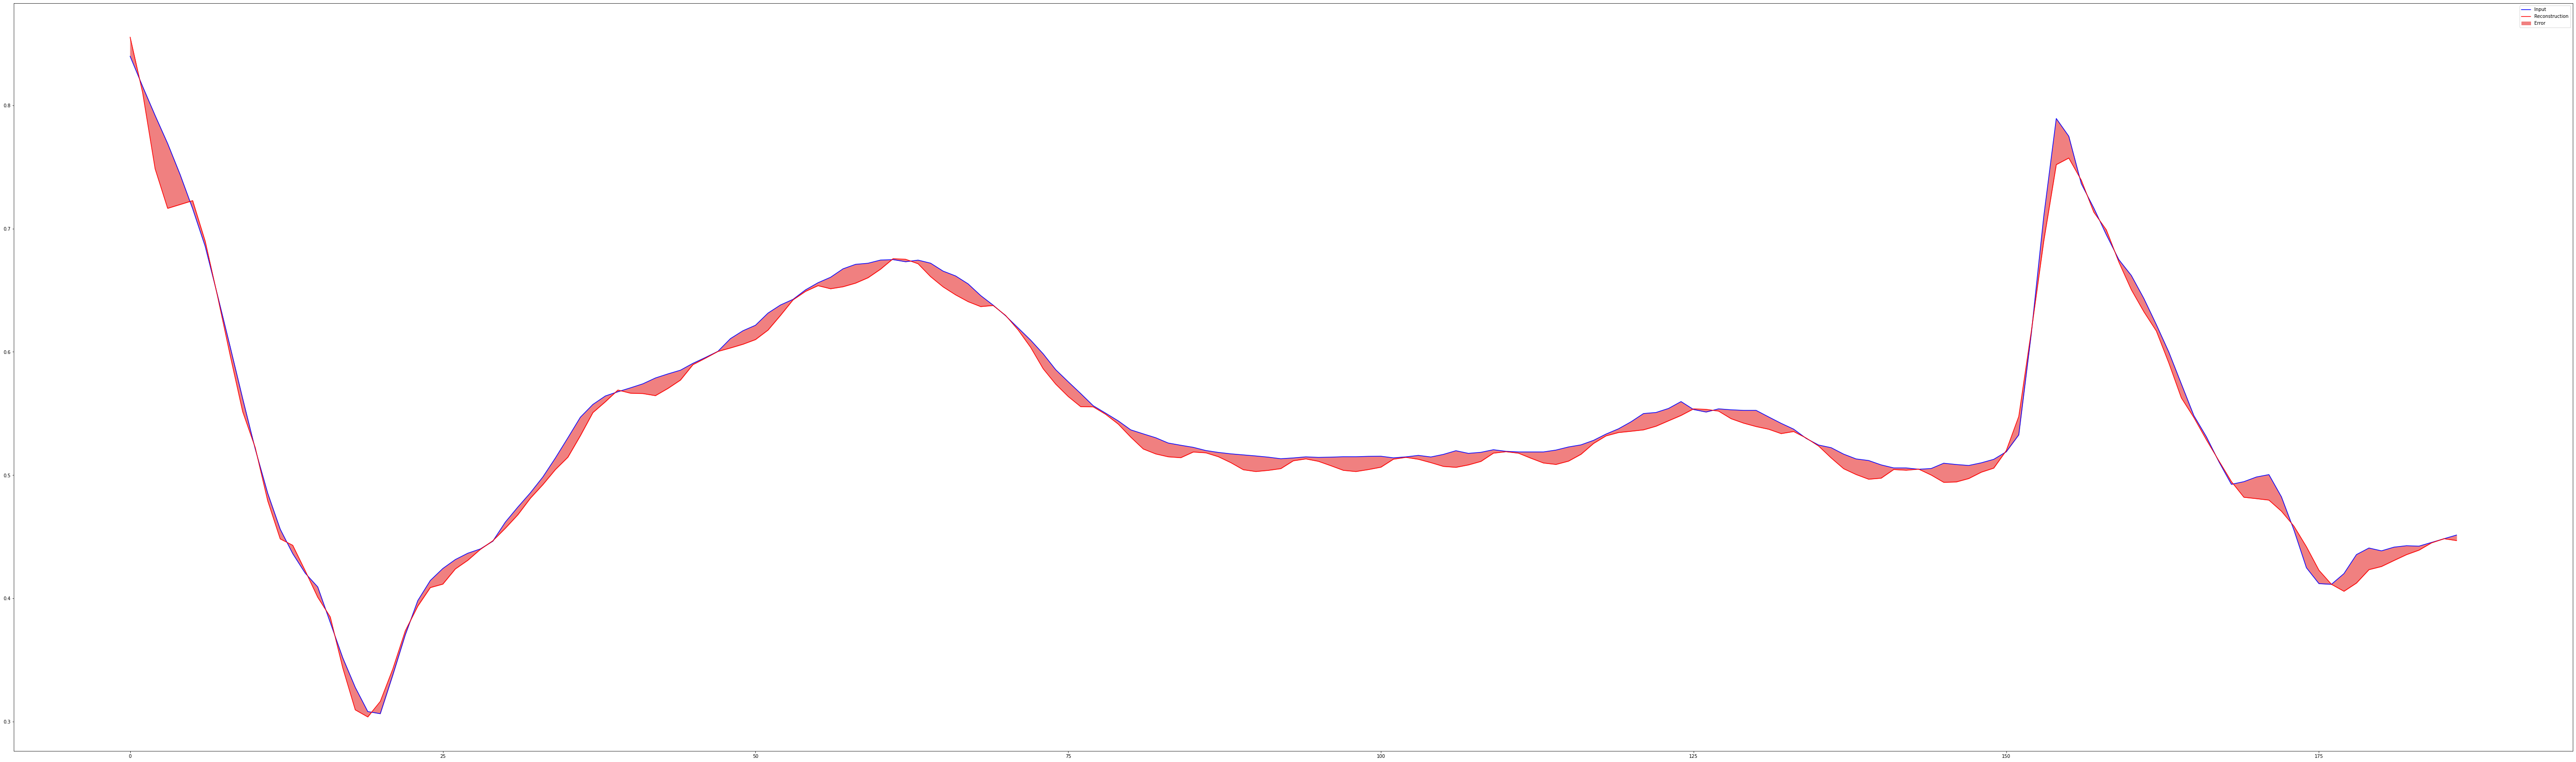

In [38]:
print("normal_recon")
recon_sample(autoencoder_conv, normal_test_data_itp)
print("abnormal_recon")
recon_sample(autoencoder_conv, anomalous_test_data_itp)

In [39]:
threshold_conv_itp = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_conv_itp)

Threshold:  0.34887677


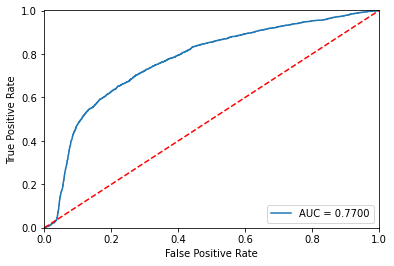

Accuracy = 0.8270230141054195


In [41]:
predict_roc(autoencoder_conv, test_data_itp, test_labels, threshold_conv_itp)

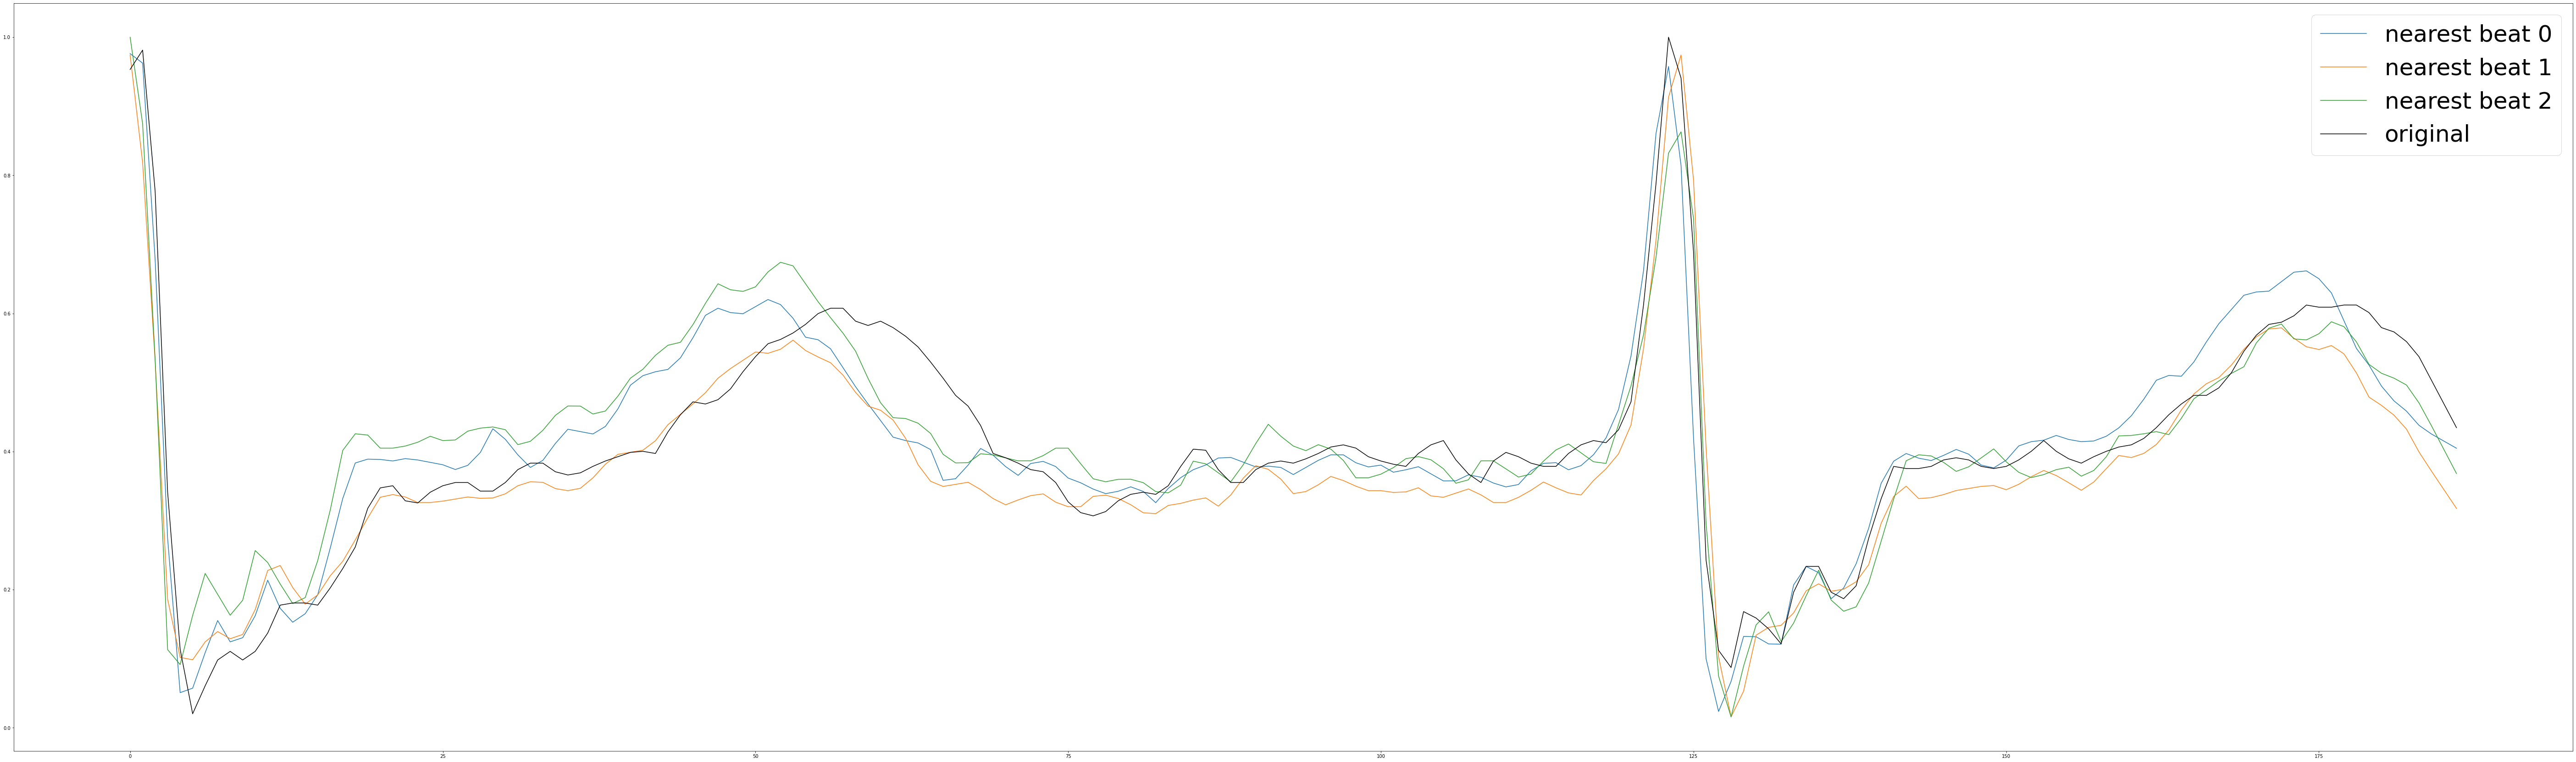

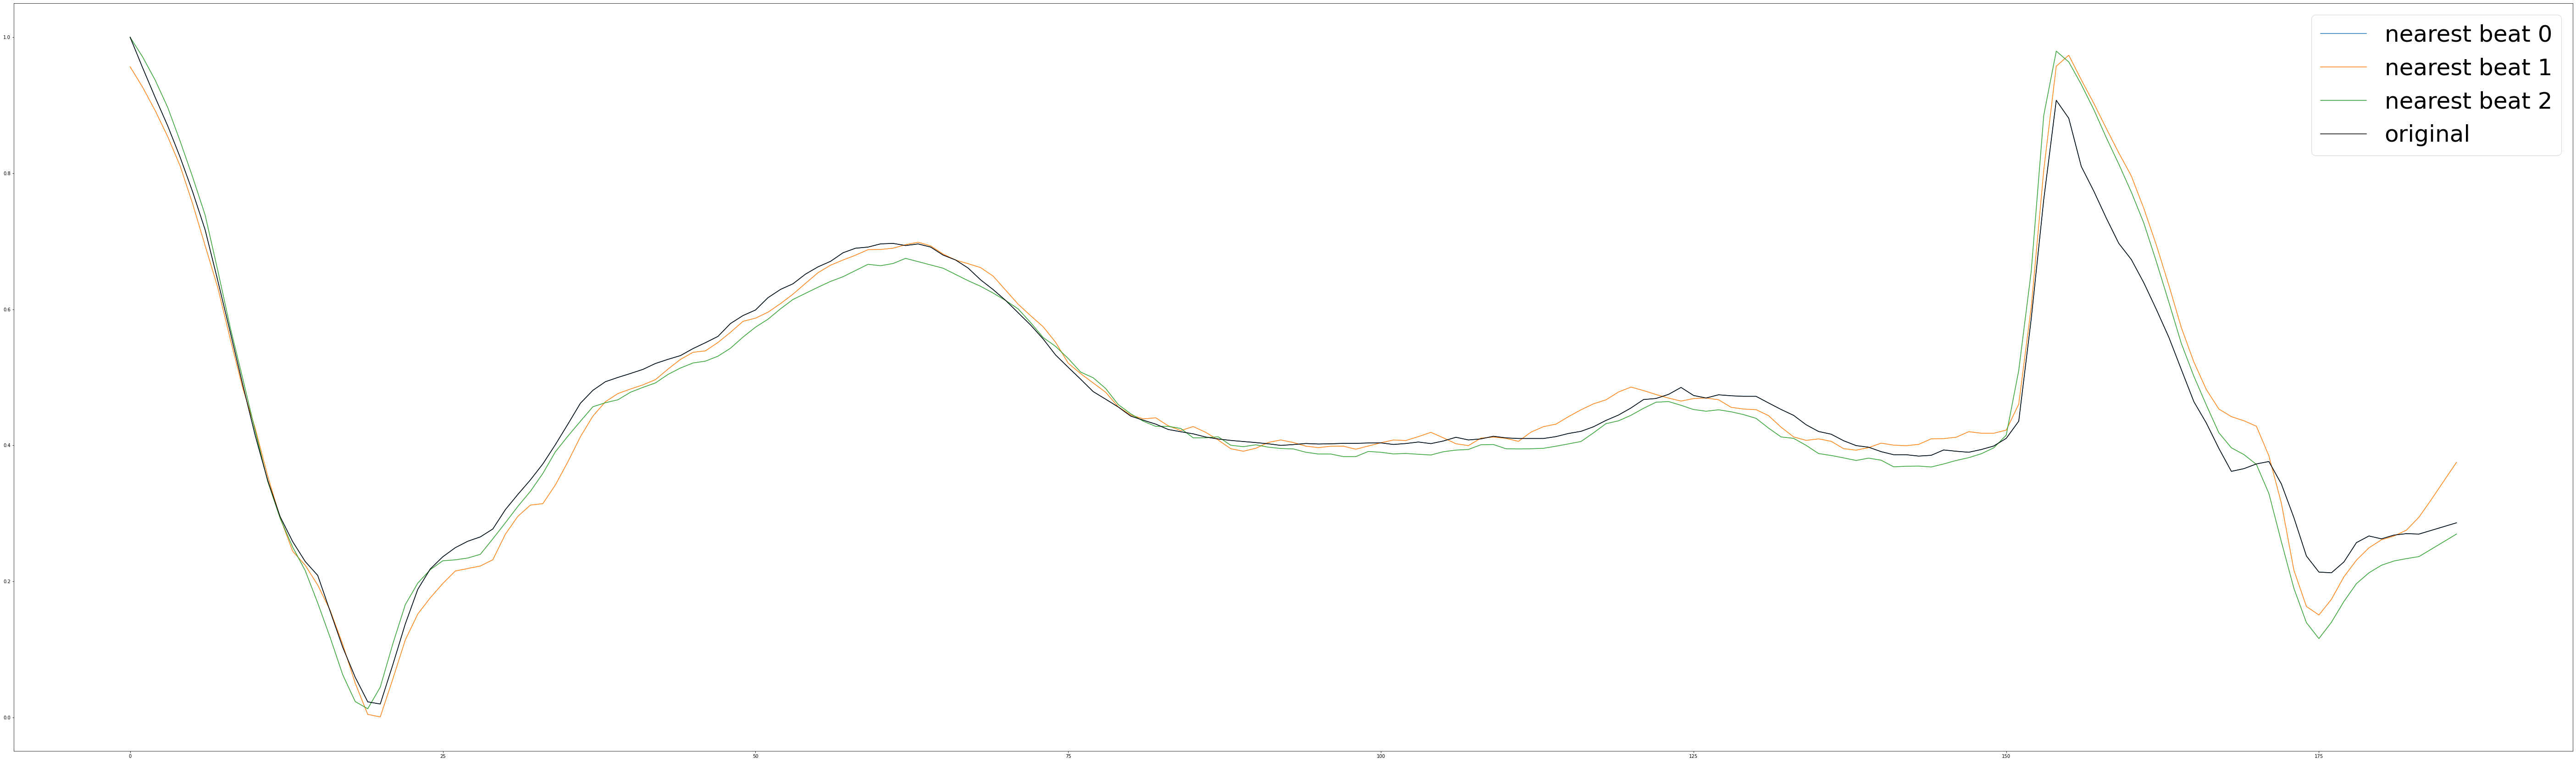

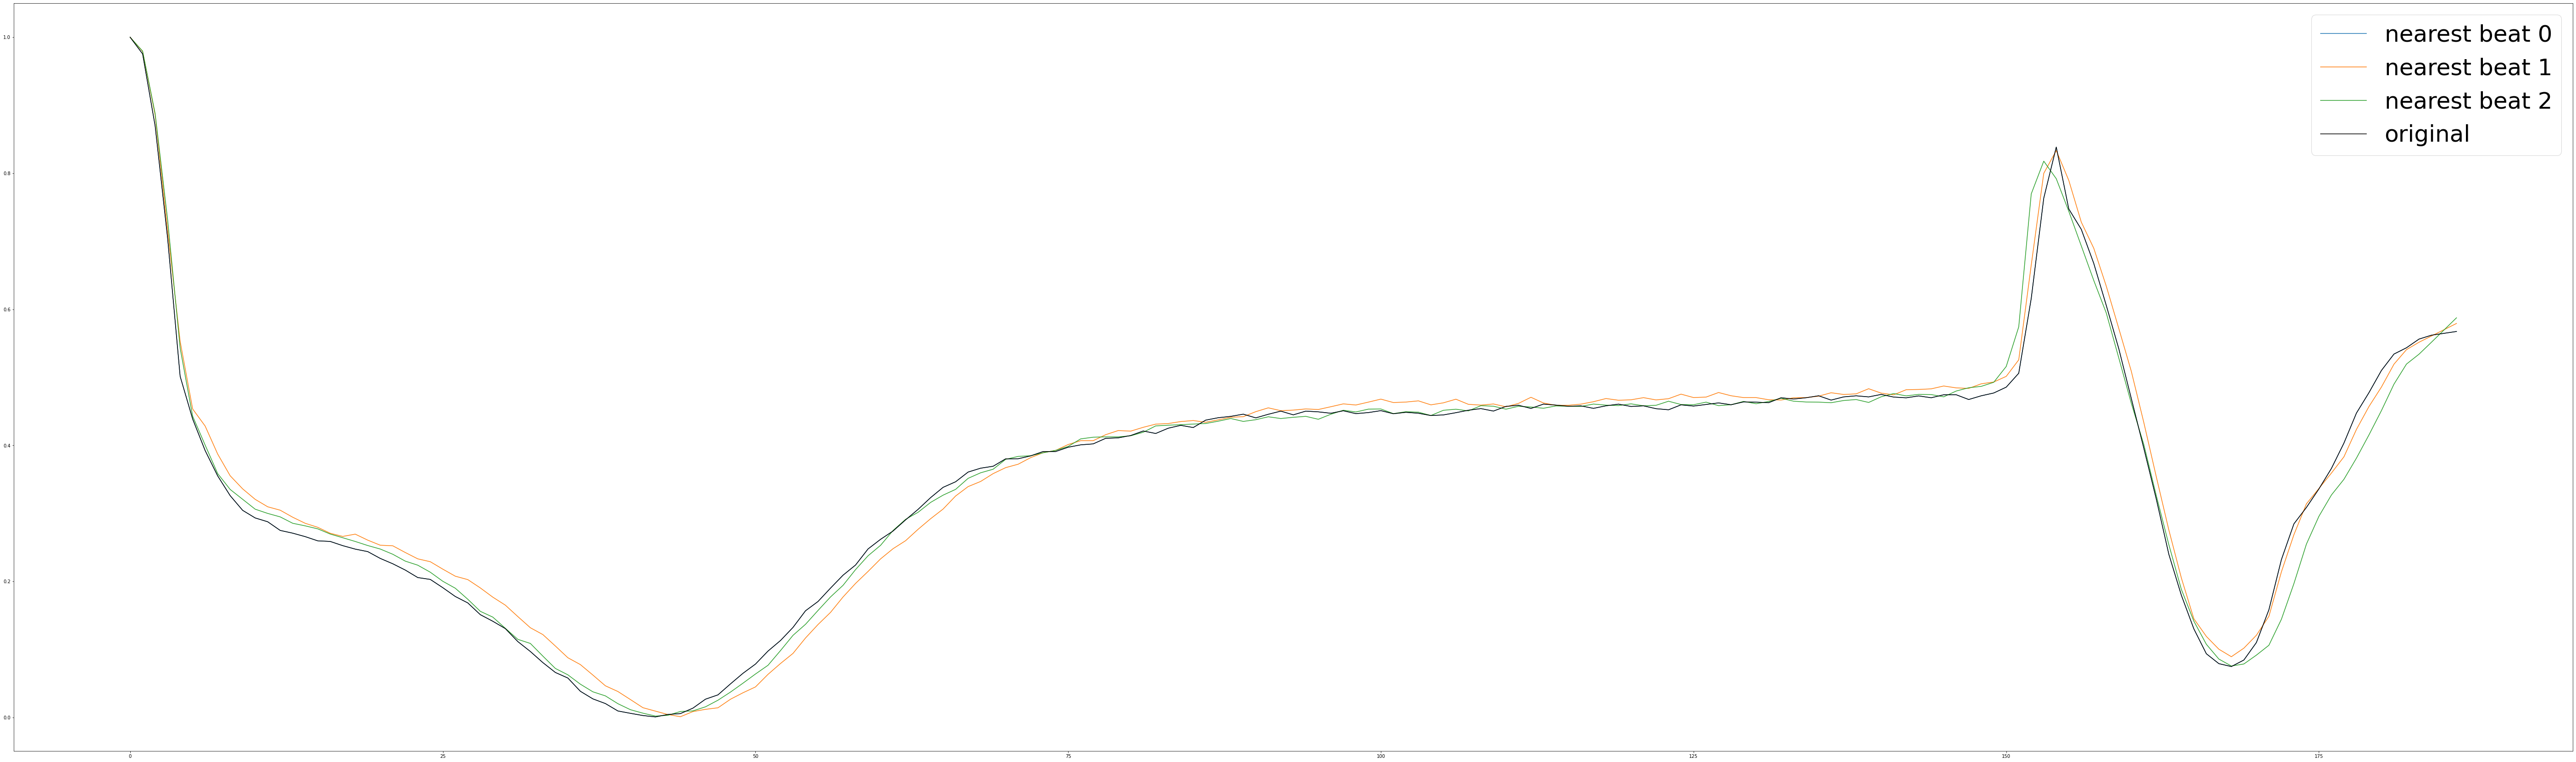

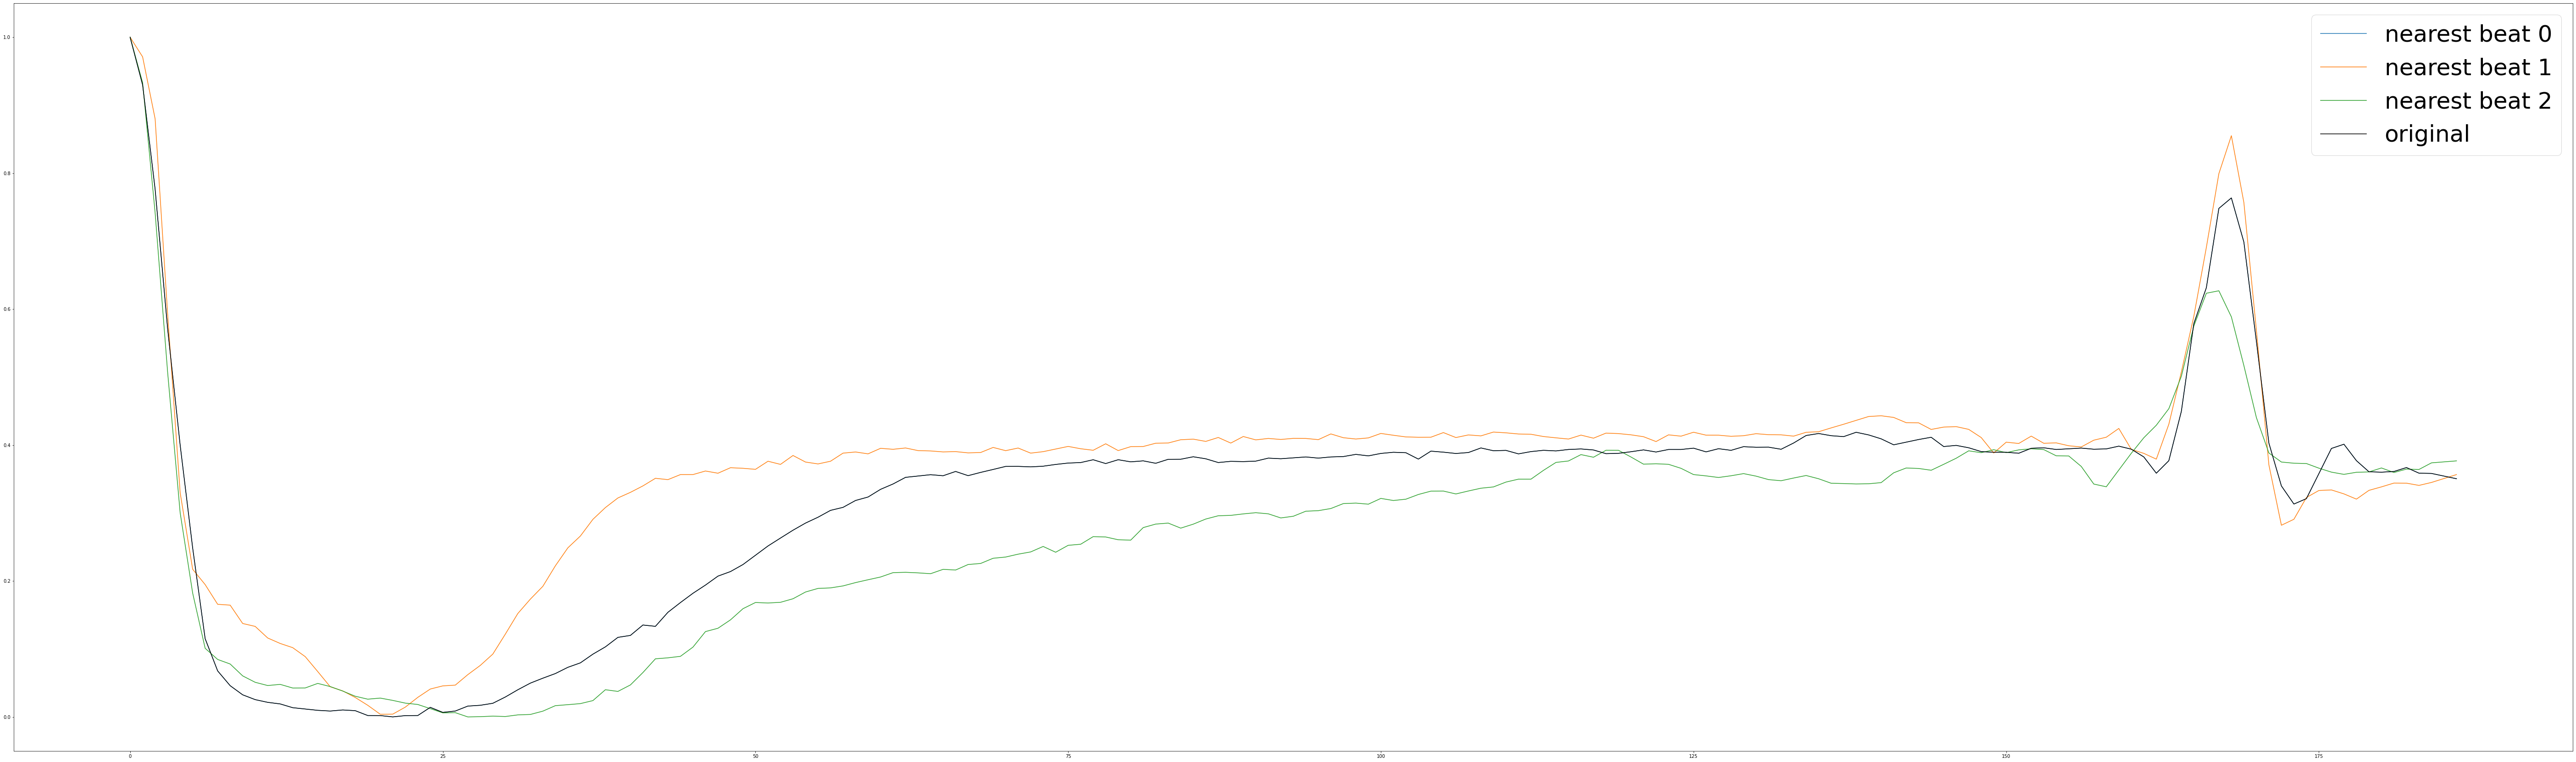

In [46]:
pred_ae_itp = predict_ae(autoencoder, test_data_itp, threshold_ae_itp)
print_knn(pred_ae_itp, MITdf_t, test_data_pure_itp)

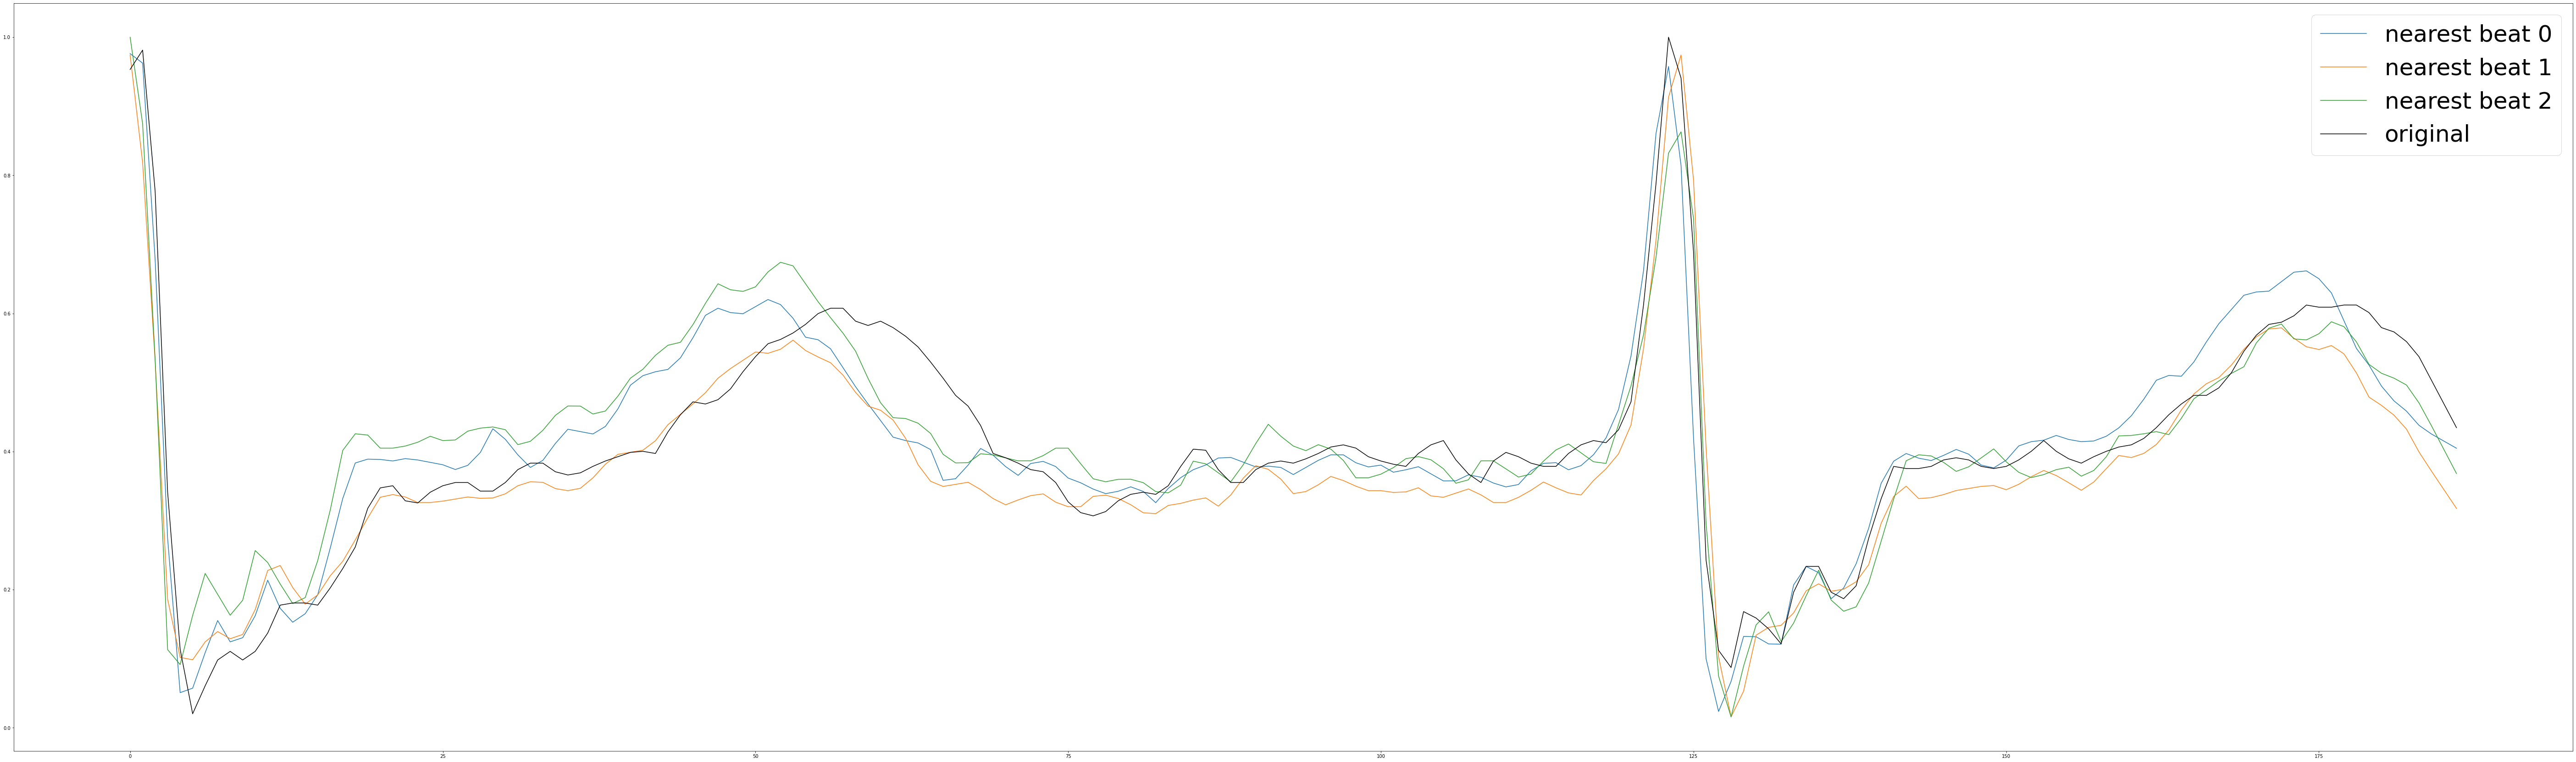

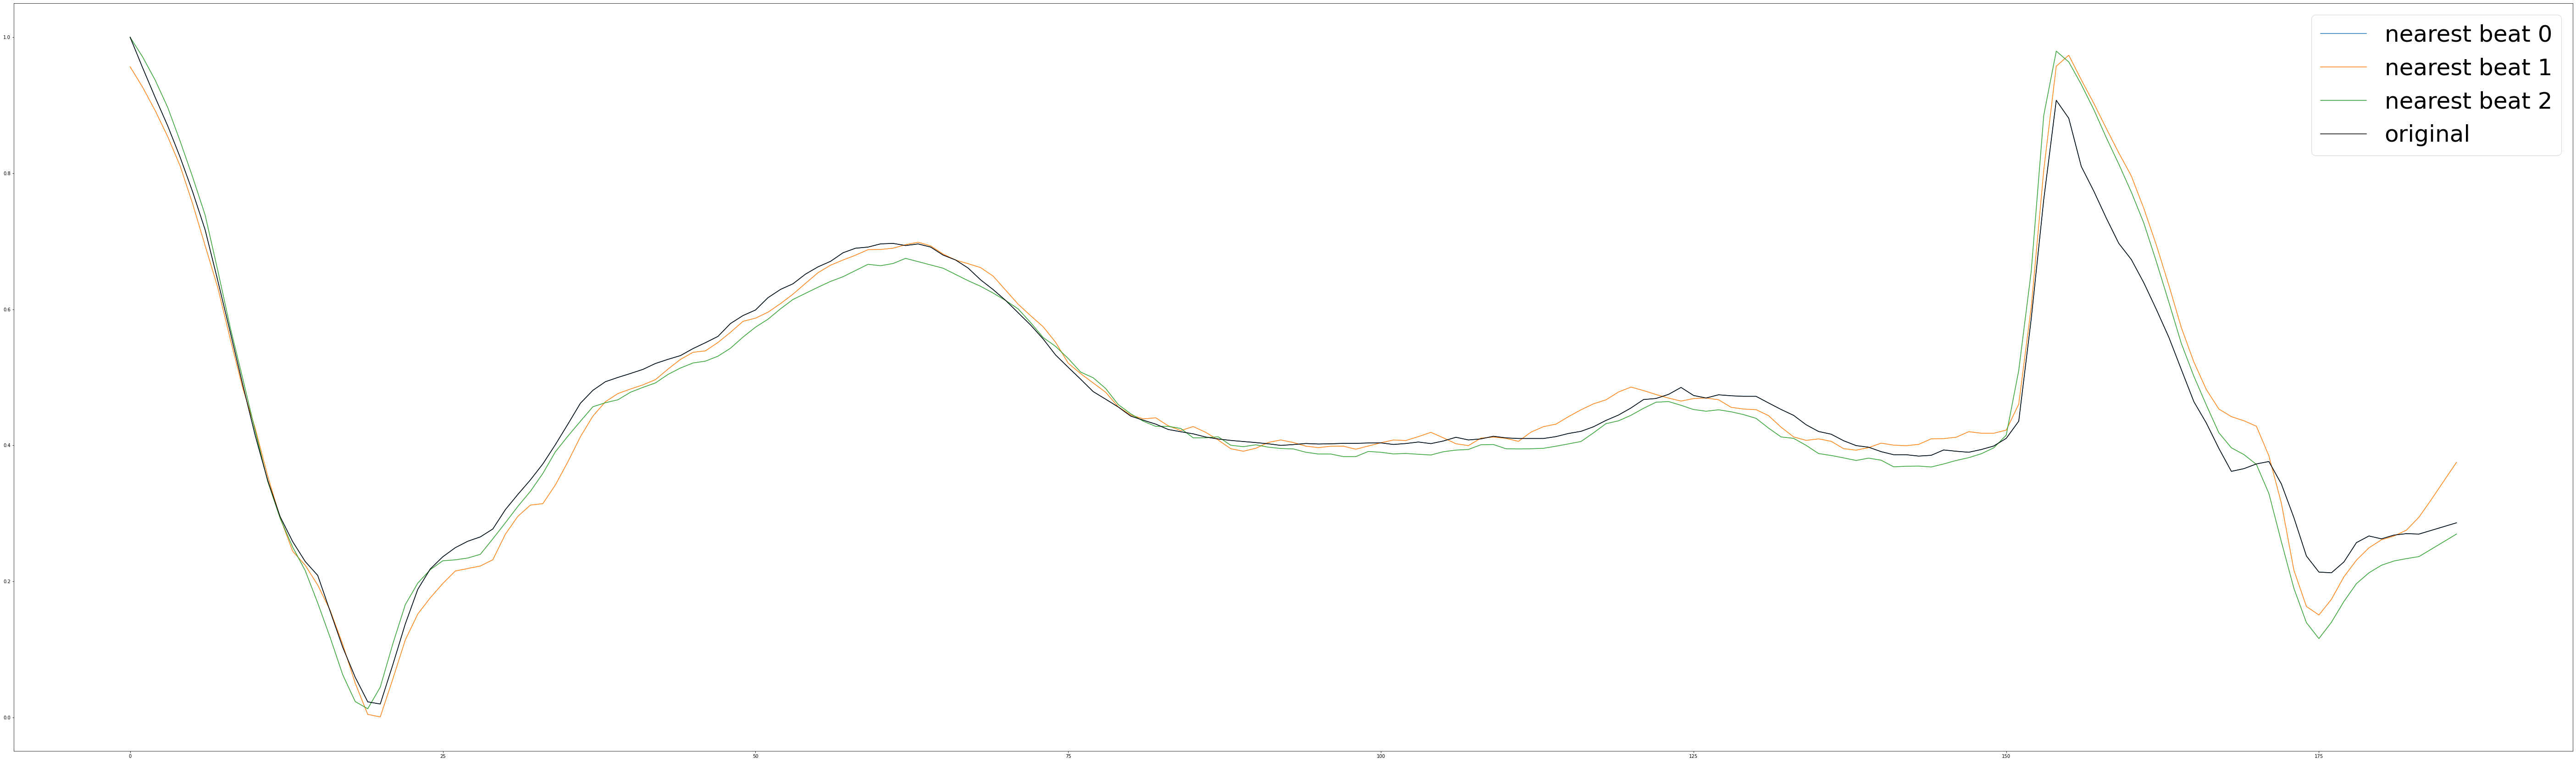

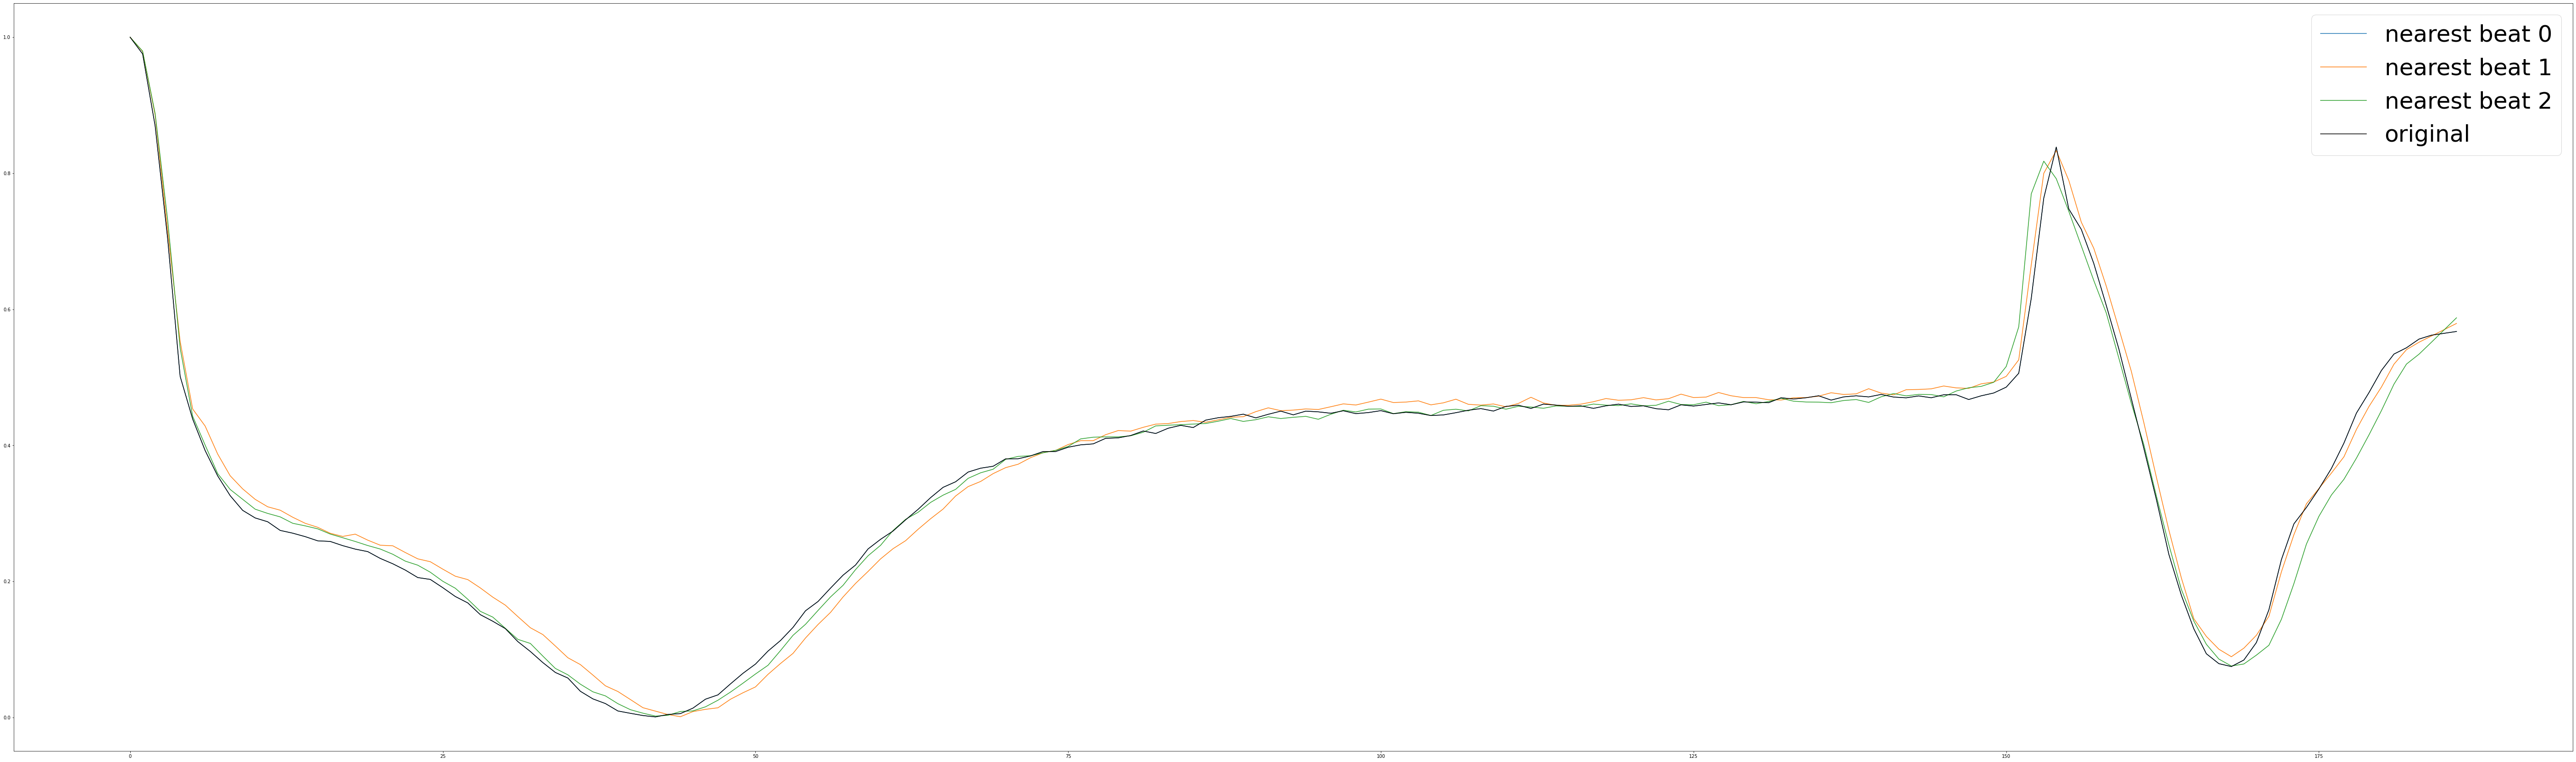

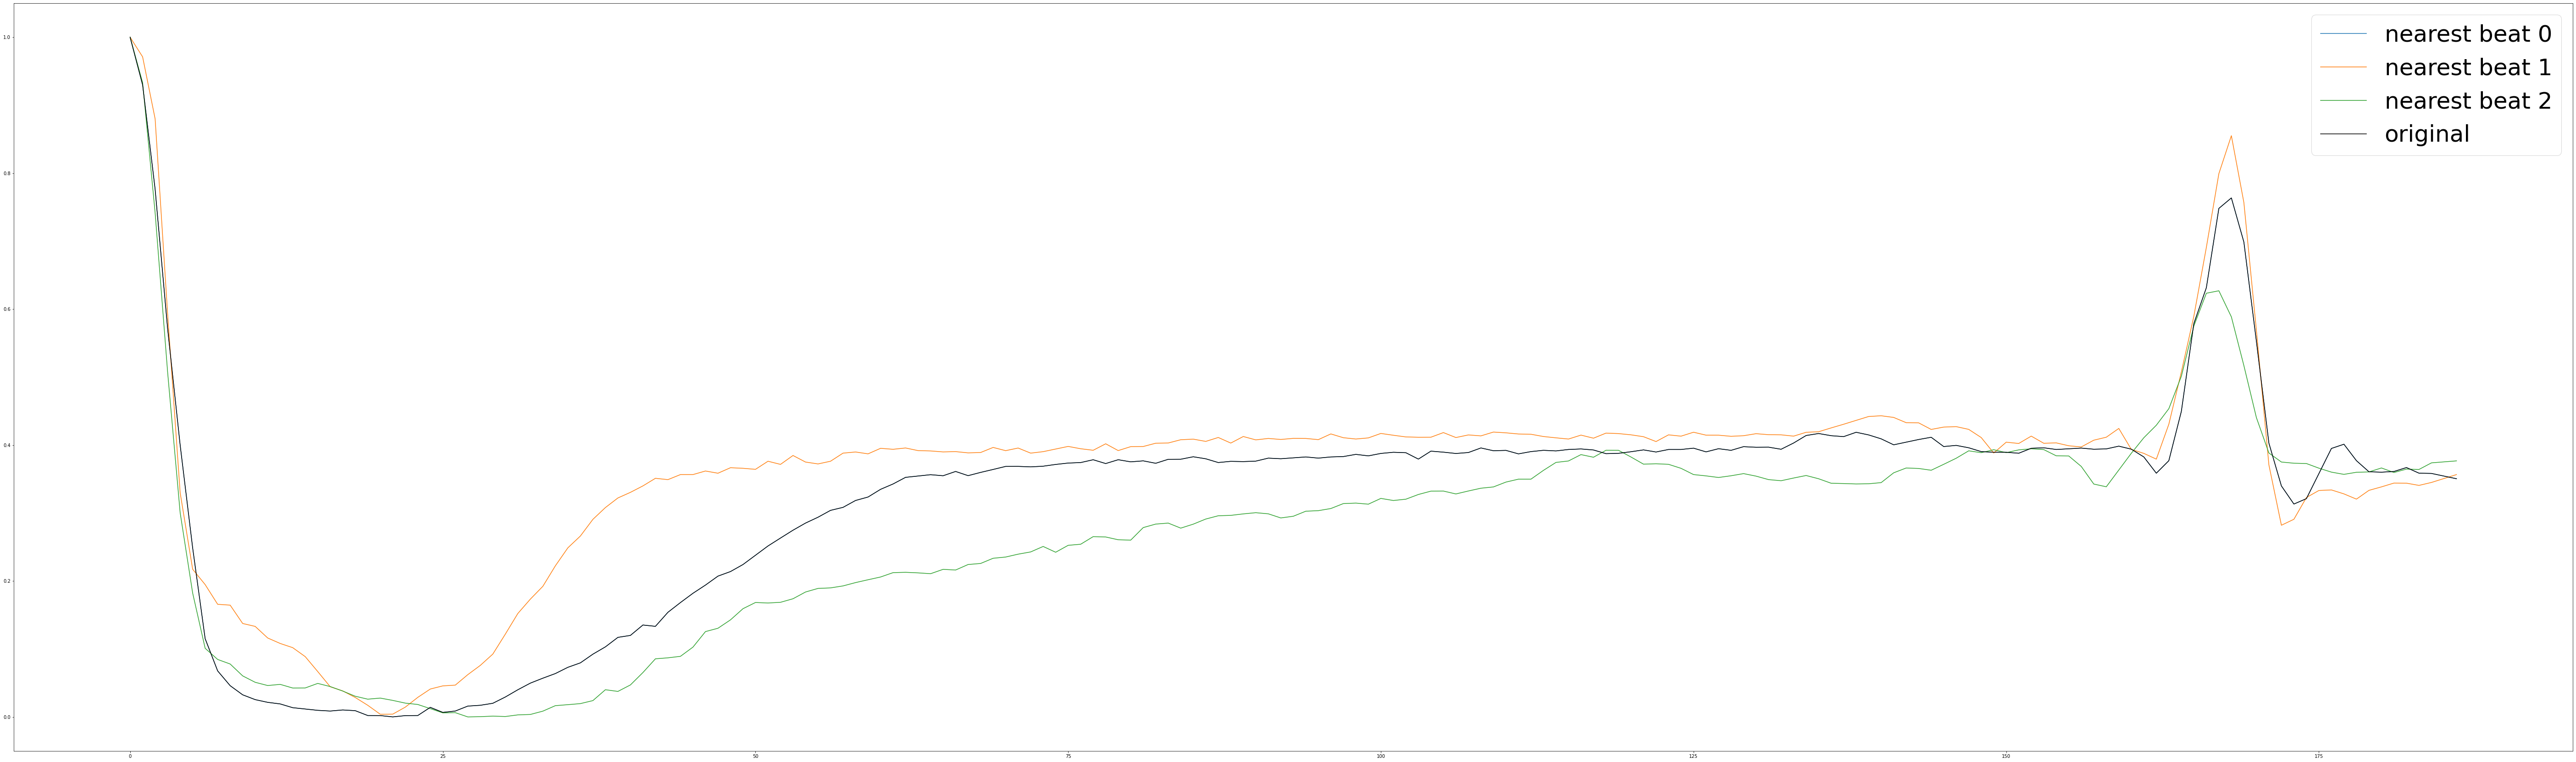

In [47]:
pred_conv_itp = predict_ae(autoencoder_conv, test_data_itp, threshold_conv_itp)
print_knn(pred_ae_itp, MITdf_t, test_data_pure_itp)